<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Jupyter notebook housekeeping

In [1]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [2]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

Check whether GPU is available

In [3]:
import torch
torch.cuda.is_available()

False

Load data from prepared local csv files

In [4]:
from darts import TimeSeries
import pandas as pd


Load stock symbols

Load price history
* Past covariates

In [5]:
stocks_file = 'data/ibdgrowth_hist.csv.bz2'

In [6]:
# load into a dataframe with valid market calendar days
stocks_df = pd.read_csv(stocks_file, header=[0, 1], index_col=0)
stocks_df



TWST                                              \
                          Open       High        Low      Close  Adj Close   
Date                                                                         
1962-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-03 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-04 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-05 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-08 00:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2024-01-08 00:00:00  33.830002  35.070000  32.799999  34.980000  34.980000   
2024-01-09 00:00:00  34.250000  37.520000  34.130001  37.150002  37.150002   
2024-01-10 00:00:00  37.080002  37.410000  35.250000  36.580002  36.580002   
2024-01-11 00:00:00  35.959999  36.259998  34.180000  35.840000  35.840000   
2024-01-12 00:00:00  36.029999  37.730000  35.919998  36.119999  36.119999   

                                      NFLX                          \
                        Volume        Open        High         Low   
Date                                                                 
1962-01-02 00:00:00        NaN         NaN         NaN         NaN   
1962-01-03 00:00:00        NaN         NaN         NaN         NaN   
1962-01-04 00:00:00        NaN         NaN         NaN         NaN   
1962-01-05 00:00:00        NaN         NaN         NaN         NaN   
1962-01-08 00:00:00        NaN         NaN         NaN         NaN   
...                        ...         ...         ...         ...   
2024-01-08 00:00:00   943300.0  473.890015  485.239990  473.649994   
2024-01-09 00:00:00  1081500.0  475.529999  485.089996  473.799988   
2024-01-10 00:00:00  1424400.0  481.600006  487.000000  472.950012   
2024-01-11 00:00:00  1188700.0  492.540009  503.410004  483.820007   
2024-01-12 00:00:00   896500.0  500.510010  500.790009  490.609985   

                                 ...       FITB                        \
                          Close  ...        Low      Close  Adj Close   
Date                             ...                                    
1962-01-02 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-03 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-04 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-05 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-08 00:00:00         NaN  ...        NaN        NaN        NaN   
...                         ...  ...        ...        ...        ...   
2024-01-08 00:00:00  485.029999  ...  34.900002  35.639999  35.639999   
2024-01-09 00:00:00  482.089996  ...  34.950001  35.310001  35.310001   
2024-01-10 00:00:00  478.329987  ...  34.919998  35.360001  35.360001   
2024-01-11 00:00:00  492.230011  ...  34.310001  34.849998  34.849998   
2024-01-12 00:00:00  492.160004  ...  34.090000  34.360001  34.360001   

                                       PNC                          \
                        Volume        Open        High         Low   
Date                                                                 
1962-01-02 00:00:00        NaN         NaN         NaN         NaN   
1962-01-03 00:00:00        NaN         NaN         NaN         NaN   
1962-01-04 00:00:00        NaN         NaN         NaN         NaN   
1962-01-05 00:00:00        NaN         NaN         NaN         NaN   
1962-01-08 00:00:00        NaN         NaN         NaN         NaN   
...                        ...         ...         ...         ...   
2024-01-08 00:00:00  4698900.0  156.000000  157.690002  154.580002   
2024-01-09 00:00:00  4248200.0  156.220001  156.220001  154.009995   
2024-01-10 00:00:00  3747900.0  154.500000  155.419998  153.210007   
2024-01-11 00:00:00  6155900.0  154.529999  154.539993  149.880005   
2024-01-12 00:00:00

In [7]:
stocks_df.columns.levels[0]

Index(['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS',
       'ALKT',
       ...
       'WSM', 'WTFC', 'XP', 'XYL', 'YELP', 'Z', 'ZG', 'ZION', 'ZS', 'ZTS'],
      dtype='object', length=309)

In [8]:
stocks_df[['ZS']]

ZS                                      \
                           Open        High         Low       Close   
Date                                                                  
1962-01-02 00:00:00         NaN         NaN         NaN         NaN   
1962-01-03 00:00:00         NaN         NaN         NaN         NaN   
1962-01-04 00:00:00         NaN         NaN         NaN         NaN   
1962-01-05 00:00:00         NaN         NaN         NaN         NaN   
1962-01-08 00:00:00         NaN         NaN         NaN         NaN   
...                         ...         ...         ...         ...   
2024-01-08 00:00:00  213.279999  219.350006  212.509995  218.100006   
2024-01-09 00:00:00  215.960007  228.149994  215.960007  226.259995   
2024-01-10 00:00:00  228.309998  230.233994  224.660004  225.399994   
2024-01-11 00:00:00  226.000000  229.910004  224.000000  228.520004   
2024-01-12 00:00:00  230.979996  233.809006  229.630005  230.770004   

                                            
                      Adj Close     Volume  
Date                                        
1962-01-02 00:00:00         NaN        NaN  
1962-01-03 00:00:00         NaN        NaN  
1962-01-04 00:00:00         NaN        NaN  
1962-01-05 00:00:00         NaN        NaN  
1962-01-08 00:00:00         NaN        NaN  
...                         ...        ...  
2024-01-08 00:00:00  218.100006  1633200.0  
2024-01-09 00:00:00  226.259995  2445800.0  
2024-01-10 00:00:00  225.399994  1880200.0  
2024-01-11 00:00:00  228.520004  1397100.0  
2024-01-12 00:00:00  230.770004  1563600.0  

[15615 rows x 6 columns]

In [9]:
import random

train_history = 252*2 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data

n_test_range_days = train_history+3*pred_horizon
print(f'n_test_range_days: {n_test_range_days}')


# minimum amount of historical data required to train on a stock series
# stocks that are too new off IPOs, are not a good fit for training this model
min_samples = n_test_range_days*3
print(f'min_samples: {min_samples}')


stocks_df.index = pd.to_datetime(stocks_df.index)

ticker_dict = {}
stock_tickers = stocks_df.columns.levels[0]
print(type(stock_tickers))


n_test_range_days: 630
min_samples: 1890
<class 'pandas.core.indexes.base.Index'>


In [10]:
print(list(stock_tickers))

['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS', 'ALKT', 'ALLE', 'ALLY', 'ALTR', 'AMD', 'AMGN', 'AMK', 'AMP', 'AMPH', 'AMZN', 'ANET', 'ANF', 'AOS', 'APO', 'ARCO', 'ARES', 'ARM', 'AROC', 'ARVN', 'ASML', 'ASND', 'ASO', 'AVGO', 'AWI', 'AX', 'AXON', 'AXP', 'AZEK', 'AZTA', 'BAC', 'BAM', 'BCO', 'BK', 'BKNG', 'BLBD', 'BLD', 'BLDR', 'BLK', 'BLKB', 'BLX', 'BMI', 'BOH', 'BR', 'BROS', 'BSX', 'BURL', 'BX', 'CADE', 'CAH', 'CAMT', 'CARR', 'CAT', 'CB', 'CCL', 'CDRE', 'CELH', 'CHKP', 'CLS', 'CMG', 'CNM', 'COF', 'COIN', 'COLB', 'COLL', 'COST', 'CRBG', 'CRH', 'CRM', 'CRS', 'CRSP', 'CRWD', 'CSWC', 'CYBR', 'DASH', 'DB', 'DBX', 'DDOG', 'DECK', 'DFH', 'DHI', 'DKS', 'DOCN', 'DOCU', 'DT', 'DUOL', 'DV', 'DXCM', 'EDU', 'ELF', 'EME', 'ENSG', 'ERIE', 'ERJ', 'ESTC', 'ETN', 'EWBC', 'EXPE', 'FBIN', 'FERG', 'FI', 'FICO', 'FITB', 'FIX', 'FLEX', 'FLR', 'FLT', 'FNF', 'FOR', 'FOUR', 'FROG', 'FRPT', 'FRSH', 'FSS', 'FTAI', 'GBDC', 'GCT', 'GDDY', 'GE', 'GEL', 'GEN', 'GFF', 'GLOB', 'GOOG', 'GOOGL', 'GPK'

In [11]:
print(stock_tickers[0])

AAON


In [12]:
n_epochs = 2 # model training epochs
n_stocks = 2

# use only a small subset of stocks while testing impact of covariates on model performance
stock_tickers = random.sample(list(stock_tickers), n_stocks)
# stock_tickers = list(stock_tickers) 
for t in stock_tickers:
    stock_full_hist = stocks_df[t].dropna()
    if len(stock_full_hist.index) >= min_samples:
        # UPDATE: Do not drop Close as it carries unique information about the relationships between OHLC and Adj Close
        # we only need Adj Close which takes into account dividends and splits
        ticker_dict[t] = stock_full_hist # .drop(columns=['Close'])
        print(f'ticker: {t}')
        print(f'ticker historic data: {ticker_dict[t]}')


ticker: SMCI
ticker historic data:                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2007-03-29    8.850000    9.310000    8.660000    8.760000    8.760000   
2007-03-30    8.830000    9.000000    8.550000    8.990000    8.990000   
2007-04-02    9.000000   10.590000    8.990000   10.380000   10.380000   
2007-04-03   10.700000   11.660000   10.400000   10.580000   10.580000   
2007-04-04   10.400000   10.990000   10.030000   10.160000   10.160000   
...                ...         ...         ...         ...         ...   
2024-01-08  294.890015  321.820007  293.519989  320.279999  320.279999   
2024-01-09  318.329987  349.179993  317.209991  343.730011  343.730011   
2024-01-10  347.000000  357.989990  332.239990  342.380005  342.380005   
2024-01-11  344.839996  355.179993  330.739990  343.309998  343.309998   
2024-01-12  345.529999  349.480011  338.290009  339.559998  339.559998   

  

In [13]:
ticker_dict.keys()

dict_keys(['SMCI', 'PNFP'])

In [14]:
type(list(ticker_dict.keys()))

list

In [15]:
list(ticker_dict.keys())[0]

'SMCI'

In [16]:
# type(raw_df.index)

In [17]:
# check for missing values
# raw_df.shape[0] - raw_df.dropna().shape[0]

In [18]:
# raw_df

In [19]:

# series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')

ticker_series = {ticker: TimeSeries.from_dataframe(ticker_dict[ticker], freq='B') for ticker in ticker_dict.keys()}
ticker_series

# series = TimeSeries.from_dataframe(raw_df, freq='B')

# raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])

# series = TimeSeries.from_csv(data_file_name, time_col='Date', freq='B')


{'SMCI': <TimeSeries (DataArray) (Date: 4382, component: 6, sample: 1)>
 array([[[8.85000038e+00],
         [9.31000042e+00],
         [8.65999985e+00],
         [8.76000023e+00],
         [8.76000023e+00],
         [6.07980000e+06]],
 
        [[8.82999992e+00],
         [9.00000000e+00],
         [8.55000019e+00],
         [8.98999977e+00],
         [8.98999977e+00],
         [4.19500000e+05]],
 
        [[9.00000000e+00],
         [1.05900002e+01],
         [8.98999977e+00],
         [1.03800001e+01],
         [1.03800001e+01],
         [7.49100000e+05]],
 ...
        [[3.47000000e+02],
         [3.57989990e+02],
         [3.32239990e+02],
         [3.42380005e+02],
         [3.42380005e+02],
         [5.34540000e+06]],
 
        [[3.44839996e+02],
         [3.55179993e+02],
         [3.30739990e+02],
         [3.43309998e+02],
         [3.43309998e+02],
         [4.17290000e+06]],
 
        [[3.45529999e+02],
         [3.49480011e+02],
         [3.38290009e+02],
         [3.3955999

Prepare multiple series - one per stock ticker

In [20]:
from darts.dataprocessing.transformers import MissingValuesFiller
filler = MissingValuesFiller()

for t, series in ticker_series.items():
    gaps = series.gaps(mode='any')
    print(f'ticker: {t} gaps: \n {gaps}')
    series_filled = filler.transform(series)
    # check for any data gaps
    gaps_filled = series_filled.gaps(mode='any')
    print(f'ticker: {t} gaps after filler: \n {gaps_filled}')
    ticker_series[t] = series_filled



ticker: SMCI gaps: 
      gap_start    gap_end  gap_size
0   2007-04-06 2007-04-06         1
1   2007-05-28 2007-05-28         1
2   2007-07-04 2007-07-04         1
3   2007-09-03 2007-09-03         1
4   2007-11-22 2007-11-22         1
..         ...        ...       ...
148 2023-07-04 2023-07-04         1
149 2023-09-04 2023-09-04         1
150 2023-11-23 2023-11-23         1
151 2023-12-25 2023-12-25         1
152 2024-01-01 2024-01-01         1

[153 rows x 3 columns]
ticker: SMCI gaps after filler: 
 Empty DataFrame
Columns: [gap_start, gap_end]
Index: []
ticker: PNFP gaps: 
      gap_start    gap_end  gap_size
0   2000-09-04 2000-09-04         1
1   2000-11-23 2000-11-23         1
2   2000-12-25 2000-12-25         1
3   2001-01-01 2001-01-01         1
4   2001-01-15 2001-01-15         1
..         ...        ...       ...
209 2023-07-04 2023-07-04         1
210 2023-09-04 2023-09-04         1
211 2023-11-23 2023-11-23         1
212 2023-12-25 2023-12-25         1
213 2024-01-01 2

In [21]:
# pick the earlies date after which data is available for all covariate series
train_date_start = pd.Timestamp('1991-01-01')

for t, series in ticker_series.items():
    ticker_series[t] = series.slice(train_date_start, series.end_time())
    print(f'ticker: {t} , {ticker_series[t]}')


ticker: SMCI , <TimeSeries (DataArray) (Date: 4382, component: 6, sample: 1)>
array([[[8.85000038e+00],
        [9.31000042e+00],
        [8.65999985e+00],
        [8.76000023e+00],
        [8.76000023e+00],
        [6.07980000e+06]],

       [[8.82999992e+00],
        [9.00000000e+00],
        [8.55000019e+00],
        [8.98999977e+00],
        [8.98999977e+00],
        [4.19500000e+05]],

       [[9.00000000e+00],
        [1.05900002e+01],
        [8.98999977e+00],
        [1.03800001e+01],
        [1.03800001e+01],
        [7.49100000e+05]],
...
       [[3.47000000e+02],
        [3.57989990e+02],
        [3.32239990e+02],
        [3.42380005e+02],
        [3.42380005e+02],
        [5.34540000e+06]],

       [[3.44839996e+02],
        [3.55179993e+02],
        [3.30739990e+02],
        [3.43309998e+02],
        [3.43309998e+02],
        [4.17290000e+06]],

       [[3.45529999e+02],
        [3.49480011e+02],
        [3.38290009e+02],
        [3.39559998e+02],
        [3.39559998e+02],

In [22]:
# add holidays as future covariates
for t, series in ticker_series.items():
    series_with_holidays = series.add_holidays(country_code='US')
    ticker_series[t] = series_with_holidays
    # print(f'ticker: {t} , {ticker_series[t]}')


In [23]:
# NOTE: tried but model requires numerical values, which complicates the data prep pipeline
#   For now, dropping these symbol categorical values and letting the model itself discover which group/sector a stock belongs to based on price behavior of covariate variables tracking sector indicies
#   The intuition is that the model will be able to discover correlated series patterns similar to the way features are learned in image understanding (and other natural unstructured data understanding).
# add stock ticker symbol as a static covariate to ticker series
# for t, s in ticker_series.items():
#    static_covs_single = pd.DataFrame(data={"symbol": [t]})
#    ticker_series[t] = s.with_static_covariates(static_covs_single)
#    print(f'target series with static covariates: {ticker_series[t]}')
#    print(f'target series static covariates: {ticker_series[t].static_covariates}')

In [24]:
ticker_series

{'SMCI': <TimeSeries (DataArray) (Date: 4382, component: 7, sample: 1)>
 array([[[8.85000038e+00],
         [9.31000042e+00],
         [8.65999985e+00],
         ...,
         [8.76000023e+00],
         [6.07980000e+06],
         [0.00000000e+00]],
 
        [[8.82999992e+00],
         [9.00000000e+00],
         [8.55000019e+00],
         ...,
         [8.98999977e+00],
         [4.19500000e+05],
         [0.00000000e+00]],
 
        [[9.00000000e+00],
         [1.05900002e+01],
         [8.98999977e+00],
         ...,
 ...
         ...,
         [3.42380005e+02],
         [5.34540000e+06],
         [0.00000000e+00]],
 
        [[3.44839996e+02],
         [3.55179993e+02],
         [3.30739990e+02],
         ...,
         [3.43309998e+02],
         [4.17290000e+06],
         [0.00000000e+00]],
 
        [[3.45529999e+02],
         [3.49480011e+02],
         [3.38290009e+02],
         ...,
         [3.39559998e+02],
         [2.28690000e+06],
         [0.00000000e+00]]])
 Coordinates:
 

In [25]:
from darts.dataprocessing.transformers import Scaler

# scale series values within [0,1] range to avoid gradient explosion
#for t, series in ticker_series.items():
#    ser_scaler = Scaler(verbose=True, n_jobs=-1)
#    series_scaled = ser_scaler.fit_transform(series=series)
#    # print(f'ticker: {t} , {series_scaled}')
#    ticker_series[t] = series_scaled
#    print(f'ticker: {t} , {ticker_series[t]}')


In [26]:
# prepare target univariate series for Close price
# target_series = {t: ticker_series[t].univariate_component('Close') for t in ticker_series.keys()}

target_columns = ['Open', 'Close', 'Volume']

def drop_non_target_columns(series):
    cols = series.columns
    non_target_columns = list(set(cols) - set(target_columns))
    new_series = series.drop_columns(col_names=non_target_columns)
    print(f'dropped non-target columns: {non_target_columns}')
    return new_series

# prepare target multivariate series for Open, Close and Volume
target_series = {t: drop_non_target_columns(s) for t,s in ticker_series.items()}

target_series

dropped non-target columns: ['Adj Close', 'holidays', 'High', 'Low']
dropped non-target columns: ['Adj Close', 'holidays', 'High', 'Low']


{'SMCI': <TimeSeries (DataArray) (Date: 4382, component: 3, sample: 1)>
 array([[[8.85000038e+00],
         [8.76000023e+00],
         [6.07980000e+06]],
 
        [[8.82999992e+00],
         [8.98999977e+00],
         [4.19500000e+05]],
 
        [[9.00000000e+00],
         [1.03800001e+01],
         [7.49100000e+05]],
 
        ...,
 
        [[3.47000000e+02],
         [3.42380005e+02],
         [5.34540000e+06]],
 
        [[3.44839996e+02],
         [3.43309998e+02],
         [4.17290000e+06]],
 
        [[3.45529999e+02],
         [3.39559998e+02],
         [2.28690000e+06]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2007-03-29 2007-03-30 ... 2024-01-12
   * component  (component) object 'Open' 'Close' 'Volume'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'PNFP': <TimeSeries (DataArray) (Date: 6104, component: 3, sample: 1)>
 array([[[4.75000000e+00],
         [4.75000000e+00],
         [2.34000000e+

Prepare Past Covariates

Target Stock's price history: Open, High, Low and Volume

In [27]:
# start with target ticker's own adjacent data: Open, High, Low, Volume
# drop Close which is the target series
# drop holidays which will be added later to future covariates
past_covariates = {t: ticker_series[t].drop_columns(col_names=target_columns + ['holidays']) for t in ticker_series.keys()}

past_covariates


{'SMCI': <TimeSeries (DataArray) (Date: 4382, component: 3, sample: 1)>
 array([[[  9.31000042],
         [  8.65999985],
         [  8.76000023]],
 
        [[  9.        ],
         [  8.55000019],
         [  8.98999977]],
 
        [[ 10.59000015],
         [  8.98999977],
         [ 10.38000011]],
 
        ...,
 
        [[357.98999023],
         [332.23999023],
         [342.38000488]],
 
        [[355.17999268],
         [330.73999023],
         [343.30999756]],
 
        [[349.48001099],
         [338.29000854],
         [339.55999756]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2007-03-29 2007-03-30 ... 2024-01-12
   * component  (component) object 'High' 'Low' 'Adj Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'PNFP': <TimeSeries (DataArray) (Date: 6104, component: 3, sample: 1)>
 array([[[ 4.75      ],
         [ 4.75      ],
         [ 4.25802422]],
 
        [[ 4.8125    ],
         [ 4

In [28]:
past_covariates.keys()

dict_keys(['SMCI', 'PNFP'])

SMCI past covariates components: Index(['High', 'Low', 'Adj Close'], dtype='object', name='component')
PNFP past covariates components: Index(['High', 'Low', 'Adj Close'], dtype='object', name='component')


Text(0, 0.5, 'Past Covariates')

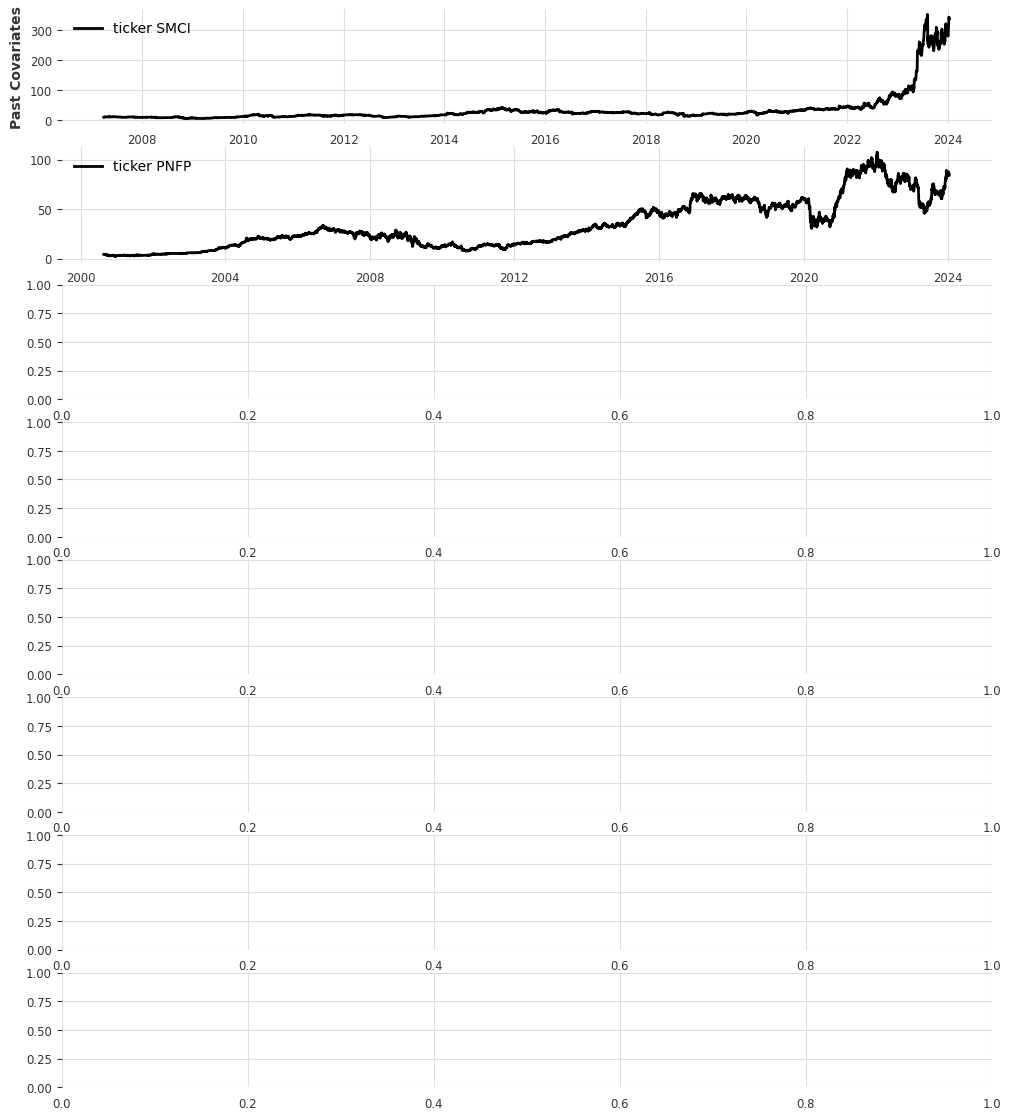

In [29]:
import matplotlib.pyplot as plt


n_plot_samples = 4
# plot sample of past covariates
fig, axes = plt.subplots(nrows=n_plot_samples*2, ncols=1, figsize=(12, 14))
for i,t in enumerate(past_covariates.keys()):
    if i < n_plot_samples:
        print(f'{t} past covariates components: {past_covariates[t].columns}')
        past_covariates[t].univariate_component('Adj Close').plot(label=f'ticker {t} ', ax=axes[i])
        # past_covariates[t].univariate_component('Volume').plot(label=f'ticker {t} Volume ', ax=axes[n_plot_samples+i])

axes[0].set_ylabel('Past Covariates')


## Prepare Past Covariates

### Add sales and earnings calendar (past and forward looking) to past covariates
* Note: Research further if the data feed provides forward looking estimates at early enough dates to be seen by the model during training. It appears that some forward looking estimates are provided with a date column with value after the actual date they have become avaible.

In [30]:
import pandas as pd

earnings_loaded_df = pd.read_csv('data/earnings_calendar.csv.bz2')
print(earnings_loaded_df)

      symbol        date      eps  epsEstimated time      revenue  \
0       MATX  2024-10-28      NaN           NaN  amc          NaN   
1       MATX  2024-07-30      NaN           NaN  amc          NaN   
2       MATX  2024-05-02      NaN           NaN  amc          NaN   
3       MATX  2024-02-20      NaN          1.55  bmo          NaN   
4       MATX  2023-10-30  3.40000          3.08  amc  827500000.0   
...      ...         ...      ...           ...  ...          ...   
33399   WING  2015-06-11  0.08936           NaN  bmo   19026000.0   
33400   WING  2014-12-31  0.05220           NaN  bmo   18057000.0   
33401   WING  2014-09-30  0.06930           NaN  bmo   16417000.0   
33402   WING  2014-06-30  0.08721           NaN  bmo   16301000.0   
33403   WING  2014-03-31  0.10380           NaN  bmo   16674000.0   

       revenueEstimated updatedFromDate fiscalDateEnding  
0                   NaN      2024-01-19       2024-09-30  
1                   NaN      2024-01-19       2024-06

In [31]:
earnings_loaded_df.index.is_unique

True

In [32]:
earnings_loaded_df.index

RangeIndex(start=0, stop=33404, step=1)

In [33]:
len(earnings_loaded_df.index)

33404

In [34]:
earnings_loaded_df['date'] = pd.to_datetime(earnings_loaded_df['date'])

In [35]:
earnings_unique = earnings_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [36]:
assert not earnings_unique.duplicated().any()

In [37]:
earnings_unique

,symbol,date,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate,fiscalDateEnding
0,MATX,2024-10-28,NaN,NaN,amc,NaN,NaN,2024-01-19,2024-09-30
1,MATX,2024-07-30,NaN,NaN,amc,NaN,NaN,2024-01-19,2024-06-30
2,MATX,2024-05-02,NaN,NaN,amc,NaN,NaN,2024-01-19,2024-03-30
3,MATX,2024-02-20,NaN,1.55,bmo,NaN,722500000.0,2024-01-19,2023-12-30
4,MATX,2023-10-30,3.40000,3.08,amc,827500000.0,794450000.0,2024-01-19,2023-09-30
...,...,...,...,...,...,...,...,...,...
33399,WING,2015-06-11,0.08936,NaN,bmo,19026000.0,NaN,2023-12-04,2015-03-31
33400,WING,2014-12-31,0.05220,NaN,bmo,18057000.0,NaN,2023-12-04,2014-12-31
33401,WING,2014-09-30,0.06930,NaN,bmo,16417000.0,NaN,2023-12-04,2014-09-30
33402,WING,2014-06-30,0.08721,NaN,bmo,16301000.0,NaN,2023-12-04,2014-06-30


In [38]:
earnings_unique = earnings_unique.set_index(keys=['symbol', 'date'])

In [39]:
earnings_unique

eps  epsEstimated time      revenue  revenueEstimated  \
symbol date                                                                    
MATX   2024-10-28      NaN           NaN  amc          NaN               NaN   
       2024-07-30      NaN           NaN  amc          NaN               NaN   
       2024-05-02      NaN           NaN  amc          NaN               NaN   
       2024-02-20      NaN          1.55  bmo          NaN       722500000.0   
       2023-10-30  3.40000          3.08  amc  827500000.0       794450000.0   
...                    ...           ...  ...          ...               ...   
WING   2015-06-11  0.08936           NaN  bmo   19026000.0               NaN   
       2014-12-31  0.05220           NaN  bmo   18057000.0               NaN   
       2014-09-30  0.06930           NaN  bmo   16417000.0               NaN   
       2014-06-30  0.08721           NaN  bmo   16301000.0               NaN   
       2014-03-31  0.10380           NaN  bmo   16674000.0               NaN   

                  updatedFromDate fiscalDateEnding  
symbol date                                         
MATX   2024-10-28      2024-01-19       2024-09-30  
       2024-07-30      2024-01-19       2024-06-30  
       2024-05-02      2024-01-19       2024-03-30  
       2024-02-20      2024-01-19       2023-12-30  
       2023-10-30      2024-01-19       2023-09-30  
...                           ...              ...  
WING   2015-06-11      2023-12-04       2015-03-31  
       2014-12-31      2023-12-04       2014-12-31  
       2014-09-30      2023-12-04       2014-09-30  
       2014-06-30      2023-12-04       2014-06-30  
       2014-03-31      2023-12-04       2014-03-31  

[33392 rows x 7 columns]

In [40]:
assert earnings_unique.index.has_duplicates == False

In [41]:
# check if data for a given symbol was saved and loaded as expected
earnings_unique.xs('LRN', level='symbol')

,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate,fiscalDateEnding
date,,,,,,,
2024-10-22,NaN,NaN,amc,NaN,NaN,2024-01-19,2024-09-30
2024-08-13,NaN,NaN,amc,NaN,NaN,2024-01-19,2024-06-30
2024-04-23,NaN,NaN,amc,NaN,NaN,2024-01-19,2024-03-30
2024-01-23,NaN,1.34,amc,NaN,500850000.0,2024-01-19,2023-12-30
2023-10-24,0.11000,-0.35,amc,480181000.0,451150000.0,2024-01-19,2023-09-30
...,...,...,...,...,...,...,...
2006-06-30,0.17150,NaN,amc,29225000.0,NaN,2023-12-04,2006-06-30
2006-03-31,0.17200,NaN,amc,29226000.0,NaN,2023-12-04,2006-03-31
2005-12-31,0.17200,NaN,amc,29226000.0,NaN,2023-12-04,2005-12-31


In [42]:
print(earnings_unique.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated updatedFromDate fiscalDateEnding
date                                                                                               
2024-10-22   NaN           NaN  amc          NaN               NaN      2024-01-19       2024-09-30
2024-08-13   NaN           NaN  amc          NaN               NaN      2024-01-19       2024-06-30
2024-04-23   NaN           NaN  amc          NaN               NaN      2024-01-19       2024-03-30
2024-01-23   NaN        1.3400  amc          NaN      5.008500e+08      2024-01-19       2023-12-30
2023-10-24  0.11       -0.3500  amc  480181000.0      4.511500e+08      2024-01-19       2023-09-30
2023-08-15  1.01        0.8700  amc  483489000.0      4.607000e+08      2023-12-04       2023-06-30
2023-04-25  1.30        1.0700  amc  470284000.0      4.607000e+08      2023-12-04       2023-03-31
2023-01-24  1.19        1.0400  amc  458435000.0               NaN      2023-12-04       2022-12-31


In [43]:
# get a clean deep copy so it is easier to debug further data cleanup steps
earnings_expanded_df = earnings_unique.copy()

In [44]:
# convert date strings to numerical representation
ufd = pd.to_datetime(earnings_expanded_df['updatedFromDate'])
ufd_year = ufd.dt.year
ufd_month = ufd.dt.month
ufd_day = ufd.dt.day

earn_n_cols = len(earnings_expanded_df.columns)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_year', value=ufd_year)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_month', value=ufd_month)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_day', value=ufd_day)
earnings_expanded_df.pop('updatedFromDate')


symbol  date      
MATX    2024-10-28    2024-01-19
        2024-07-30    2024-01-19
        2024-05-02    2024-01-19
        2024-02-20    2024-01-19
        2023-10-30    2024-01-19
                         ...    
WING    2015-06-11    2023-12-04
        2014-12-31    2023-12-04
        2014-09-30    2023-12-04
        2014-06-30    2023-12-04
        2014-03-31    2023-12-04
Name: updatedFromDate, Length: 33392, dtype: object

In [45]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated fiscalDateEnding  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year
date                                                                                                                                                 
2024-10-22   NaN           NaN  amc          NaN               NaN       2024-09-30                   19                      1                  2024
2024-08-13   NaN           NaN  amc          NaN               NaN       2024-06-30                   19                      1                  2024
2024-04-23   NaN           NaN  amc          NaN               NaN       2024-03-30                   19                      1                  2024
2024-01-23   NaN        1.3400  amc          NaN      5.008500e+08       2023-12-30                   19                      1                  2024
2023-10-24  0.11       -0.3500  amc  480181000.0      4.511500e+08       2023-09-30                 

In [46]:
# convert date strings to numerical representation
fde = pd.to_datetime(earnings_expanded_df['fiscalDateEnding'])
fde_year = fde.dt.year
fde_month = fde.dt.month
fde_day = fde.dt.day

earn_n_cols = len(earnings_expanded_df.columns)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_year', value=fde_year)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_month', value=fde_month)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_day', value=fde_day)
earnings_expanded_df.pop('fiscalDateEnding')


symbol  date      
MATX    2024-10-28    2024-09-30
        2024-07-30    2024-06-30
        2024-05-02    2024-03-30
        2024-02-20    2023-12-30
        2023-10-30    2023-09-30
                         ...    
WING    2015-06-11    2015-03-31
        2014-12-31    2014-12-31
        2014-09-30    2014-09-30
        2014-06-30    2014-06-30
        2014-03-31    2014-03-31
Name: fiscalDateEnding, Length: 33392, dtype: object

In [47]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                     
2024-10-22   NaN           NaN  amc          NaN               NaN                   19                      1                  2024                    30                       9                   2024
2024-08-13   NaN           NaN  amc          NaN               NaN                   19                      1                  2024                    30                       6                   2024
2024-04-23   NaN           NaN  amc          NaN               NaN                   19                      1                  2024                    30                       3              

In [48]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
earnings_expanded_df['time'] = earnings_expanded_df['time'].replace(['bmo', 'amc', '--', 'dmh'],
                        [0, 1, -1, -1], inplace=False).astype('int32')



In [49]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated  time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                      
2024-10-22   NaN           NaN     1          NaN               NaN                   19                      1                  2024                    30                       9                   2024
2024-08-13   NaN           NaN     1          NaN               NaN                   19                      1                  2024                    30                       6                   2024
2024-04-23   NaN           NaN     1          NaN               NaN                   19                      1                  2024                    30                       3         

In [50]:
from darts import TimeSeries

type(earnings_expanded_df.index)

pandas.core.indexes.multi.MultiIndex

In [51]:
earnings_expanded_df.index.names

FrozenList(['symbol', 'date'])

In [52]:
earnings_expanded_df.dtypes

eps                       float64
epsEstimated              float64
time                        int32
revenue                   float64
revenueEstimated          float64
updatedFromDate_day         int32
updatedFromDate_month       int32
updatedFromDate_year        int32
fiscalDateEnding_day        int32
fiscalDateEnding_month      int32
fiscalDateEnding_year       int32
dtype: object

In [53]:
# credit for implementation: https://stackoverflow.com/a/39068260/12015435
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))


In [54]:
t_earn = earnings_expanded_df.loc[['LRN']]
t_earn = t_earn.droplevel('symbol')
t_earn.index = pd.to_datetime(t_earn.index)
print(f'index type for {t}: {type(t_earn.index)}')
assert not t_earn.index.duplicated().any()

for i in t_earn.index:
    if not is_business_day(i):
        print(f'earnings record date is not a business day: \n{t_earn.loc[[i]]}')



index type for PNFP: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
earnings record date is not a business day: 
               eps  epsEstimated  time     revenue  revenueEstimated  \
date                                                                   
2007-09-30  0.1201           NaN     1  27196000.0               NaN   

            updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  \
date                                                                           
2007-09-30                    4                     12                  2023   

            fiscalDateEnding_day  fiscalDateEnding_month  \
date                                                       
2007-09-30                    30                       9   

            fiscalDateEnding_year  
date                               
2007-09-30                   2007  
earnings record date is not a business day: 
                eps  epsEstimated  time     revenue  revenueEstimated  \
date           

In [55]:
len(t_earn.index)

78

In [56]:
# align all dates with Business days
from pandas.tseries.offsets import BDay

def to_biz_day(date=None, report_time=None):
    if not is_business_day(date):
        if report_time == 1 or report_time =='amc':
                return date-BDay(n=1)
        else: 
            return date+BDay(n=1)
    else:
         return date

def align_to_business_days(t_earn=None):
    assert not t_earn.index.isnull().any()
    new_index = t_earn.index.map(lambda x : to_biz_day(date=x, report_time=t_earn.at[x, 'time']))
    t_earn.index = new_index
    if t_earn.index.isnull().any():
         print(t_earn[t_earn.index.isnull()])
    for i in t_earn.index:
        assert is_business_day(i)
    return t_earn


In [57]:
# backfill quarterly earnigs and revenue estimates so that the model can see the next quarter's estimates during the previou s quarter days

def back_fill_earn_estimates(t_earn=None):
    t_earn['time'].bfill(inplace=True)
    t_earn['epsEstimated'].bfill(inplace=True)
    t_earn['revenueEstimated'].bfill(inplace=True)
    t_earn['fiscalDateEnding_day'].bfill(inplace=True)
    t_earn['fiscalDateEnding_month'].bfill(inplace=True)
    t_earn['fiscalDateEnding_year'].bfill(inplace=True)
    return t_earn



In [58]:
# convert earnings dataframe to series

t_earn_series = {}
for t in list(ticker_series.keys()):
    print(f'ticker: {t}')
    t_earn = earnings_expanded_df.loc[[t]].copy()
    t_earn = t_earn.droplevel('symbol')
    t_earn.index = pd.to_datetime(t_earn.index)
    print(f'index type for {t}: {type(t_earn.index)}')
    assert not t_earn.index.duplicated().any()
    assert not t_earn.index.isnull().any()
    t_earn = align_to_business_days(t_earn)
    print(f't_earn freq: {t_earn.index}')
    tes_tmp = TimeSeries.from_dataframe(t_earn, freq='B', fill_missing_dates=True)
    t_earn = back_fill_earn_estimates(t_earn=tes_tmp.pd_dataframe())
    tes = TimeSeries.from_dataframe(t_earn, fillna_value=-1)
    assert len(tes.gaps()) == 0
    t_earn_series[t] = tes


ticker: SMCI
index type for SMCI: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
t_earn freq: DatetimeIndex(['2024-10-30', '2024-08-06', '2024-04-30', '2024-01-30',
               '2023-11-01', '2023-08-08', '2023-05-02', '2023-01-31',
               '2022-11-01', '2022-08-09', '2022-05-03', '2022-02-01',
               '2021-11-02', '2021-08-10', '2021-05-04', '2021-02-02',
               '2020-11-03', '2020-08-11', '2020-05-07', '2020-02-06',
               '2019-12-20', '2019-06-28', '2019-03-29', '2018-12-31',
               '2018-09-28', '2018-06-29', '2018-03-30', '2017-12-29',
               '2017-09-29', '2017-08-03', '2017-04-27', '2017-01-26',
               '2016-10-27', '2016-08-04', '2016-04-28', '2016-01-28',
               '2015-10-22', '2015-08-04', '2015-04-21', '2015-01-20',
               '2014-10-21', '2014-08-05', '2014-04-22', '2014-01-21',
               '2013-10-22', '2013-08-06', '2013-04-23', '2013-01-22',
               '2012-10-23', '2012-08-07', '201

In [59]:
t

'PNFP'

In [60]:
t_earn


component,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate_day,updatedFromDate_month,updatedFromDate_year,fiscalDateEnding_day,fiscalDateEnding_month,fiscalDateEnding_year
date,,,,,,,,,,,
2000-03-31,-0.0228,0.04,1.0,NaN,2891937.0,4.0,12.0,2023.0,31.0,3.0,2000.0
2000-04-03,NaN,0.04,1.0,NaN,2891937.0,NaN,NaN,NaN,31.0,12.0,2000.0
2000-04-04,NaN,0.04,1.0,NaN,2891937.0,NaN,NaN,NaN,31.0,12.0,2000.0
2000-04-05,NaN,0.04,1.0,NaN,2891937.0,NaN,NaN,NaN,31.0,12.0,2000.0
2000-04-06,NaN,0.04,1.0,NaN,2891937.0,NaN,NaN,NaN,31.0,12.0,2000.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,30.0,12.0,2024.0
2025-01-09,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,30.0,12.0,2024.0
2025-01-10,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,30.0,12.0,2024.0


In [61]:
print(t_earn.tail(n=330).to_string(index=True))

component    eps  epsEstimated  time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                      
2023-10-11   NaN          1.71   1.0          NaN       421820000.0                  NaN                    NaN                   NaN                  30.0                     9.0                 2023.0
2023-10-12   NaN          1.71   1.0          NaN       421820000.0                  NaN                    NaN                   NaN                  30.0                     9.0                 2023.0
2023-10-13   NaN          1.71   1.0          NaN       421820000.0                  NaN                    NaN                   NaN                  30.0                     9.0         

In [62]:
t_earn.index

DatetimeIndex(['2000-03-31', '2000-04-03', '2000-04-04', '2000-04-05',
               '2000-04-06', '2000-04-07', '2000-04-10', '2000-04-11',
               '2000-04-12', '2000-04-13',
               ...
               '2025-01-01', '2025-01-02', '2025-01-03', '2025-01-06',
               '2025-01-07', '2025-01-08', '2025-01-09', '2025-01-10',
               '2025-01-13', '2025-01-14'],
              dtype='datetime64[ns]', name='date', length=6468, freq='B')

In [63]:
tes.pd_dataframe()

component,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate_day,updatedFromDate_month,updatedFromDate_year,fiscalDateEnding_day,fiscalDateEnding_month,fiscalDateEnding_year
date,,,,,,,,,,,
2000-03-31,-0.0228,0.04,1.0,-1.0,2891937.0,4.0,12.0,2023.0,31.0,3.0,2000.0
2000-04-03,-1.0000,0.04,1.0,-1.0,2891937.0,-1.0,-1.0,-1.0,31.0,12.0,2000.0
2000-04-04,-1.0000,0.04,1.0,-1.0,2891937.0,-1.0,-1.0,-1.0,31.0,12.0,2000.0
2000-04-05,-1.0000,0.04,1.0,-1.0,2891937.0,-1.0,-1.0,-1.0,31.0,12.0,2000.0
2000-04-06,-1.0000,0.04,1.0,-1.0,2891937.0,-1.0,-1.0,-1.0,31.0,12.0,2000.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08,-1.0000,-1.00,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,30.0,12.0,2024.0
2025-01-09,-1.0000,-1.00,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,30.0,12.0,2024.0
2025-01-10,-1.0000,-1.00,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,30.0,12.0,2024.0


In [64]:
t_earn_series

{'SMCI': <TimeSeries (DataArray) (date: 5240, component: 11, sample: 1)>
 array([[[ 6.022e-02],
         [ 1.200e-01],
         [ 1.000e+00],
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.004e+03]],
 
        [[-1.000e+00],
         [ 1.200e-01],
         [ 1.000e+00],
         ...,
         [ 3.100e+01],
         [ 1.200e+01],
         [ 2.004e+03]],
 
        [[-1.000e+00],
         [ 1.200e-01],
         [ 1.000e+00],
         ...,
 ...
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]],
 
        [[-1.000e+00],
         [-1.000e+00],
         [ 1.000e+00],
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]],
 
        [[-1.000e+00],
         [-1.000e+00],
         [ 1.000e+00],
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]]])
 Coordinates:
   * date       (date) datetime64[ns] 2004-09-30 2004-10-01 ... 2024-10-30
   * component  (component) object 'eps' ... 

In [65]:
# stack sales and earnigns to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    print(f'stacking future covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_earn_series[t])
    earn_sliced = t_earn_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(earn_sliced)
    print(f'past covariates for {t} including earnings calendar: \n{new_past_covs[t].components}')
    print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



stacking future covs for SMCI
past covariates for SMCI including earnings calendar: 
Index(['High', 'Low', 'Adj Close', 'eps', 'epsEstimated', 'time', 'revenue',
       'revenueEstimated', 'updatedFromDate_day', 'updatedFromDate_month',
       'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year'],
      dtype='object', name='component')
past covariates for SMCI start time: 2007-03-29 00:00:00, end time: 2024-01-12 00:00:00
past covariates for SMCI sample: 
component   High   Low  Adj Close  eps  epsEstimated  time  revenue  \
Date                                                                  
2007-03-29  9.31  8.66       8.76 -1.0          0.12   1.0     -1.0   

component   revenueEstimated  updatedFromDate_day  updatedFromDate_month  \
Date                                                                       
2007-03-29      9.505714e+07                 -1.0                   -1.0   

component   updatedFromDate_year  fiscalDate

In [66]:
past_covariates = new_past_covs

In [67]:
t

'PNFP'

In [68]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('2000-08-22 00:00:00'), Timestamp('2024-01-12 00:00:00'))

In [69]:
print(f'past covariates with price and earnings sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with price and earnings sample: component      High   Low  Adj Close  eps  epsEstimated  time  revenue  \
Date                                                                     
2000-08-22  4.75000  4.75   4.258024 -1.0          0.04   1.0     -1.0   
2000-08-23  4.81250  4.75   4.314051 -1.0          0.04   1.0     -1.0   
2000-08-24  4.81250  4.75   4.258024 -1.0          0.04   1.0     -1.0   
2000-08-25  4.81250  4.75   4.286037 -1.0          0.04   1.0     -1.0   
2000-08-28  4.78125  4.75   4.258024 -1.0          0.04   1.0     -1.0   

component   revenueEstimated  updatedFromDate_day  updatedFromDate_month  \
Date                                                                       
2000-08-22         2891937.0                 -1.0                   -1.0   
2000-08-23         2891937.0                 -1.0                   -1.0   
2000-08-24         2891937.0                 -1.0                   -1.0   
2000-08-25         2891937.0                 -1.0    

In [70]:
t_earn_series[t].start_time(), t_earn_series[t].end_time()

(Timestamp('2000-03-31 00:00:00'), Timestamp('2025-01-14 00:00:00'))

### Add key metrics to past covariates

In [71]:
kms_file = 'data/keymetrics_history.csv.bz2'


In [72]:
import pandas as pd

kms_loaded_df = pd.read_csv(kms_file)
print(kms_loaded_df)

      symbol        date  calendarYear period  revenuePerShare  \
0       MATX  2023-09-30          2023     Q3        23.575499   
1       MATX  2023-06-30          2023     Q2        21.785915   
2       MATX  2023-03-31          2023     Q1        19.523546   
3       MATX  2022-12-31          2022     Q4        21.723577   
4       MATX  2022-09-30          2022     Q3        29.107050   
...      ...         ...           ...    ...              ...   
32826   WING  2015-03-31          2015     Q1         0.665683   
32827   WING  2014-12-31          2014     Q4         0.634916   
32828   WING  2014-09-30          2014     Q3         0.577250   
32829   WING  2014-06-30          2014     Q2         0.573172   
32830   WING  2014-03-29          2014     Q1         0.586287   

       netIncomePerShare  operatingCashFlowPerShare  freeCashFlowPerShare  \
0               3.415954                   4.347578              2.603989   
1               2.276056                   4.219718  

In [73]:
assert kms_loaded_df.index.is_unique

In [74]:
kms_loaded_df.index

RangeIndex(start=0, stop=32831, step=1)

In [75]:
len(kms_loaded_df.index)

32831

In [76]:
kms_loaded_df['date'] = pd.to_datetime(kms_loaded_df['date'])

In [77]:
kms_unique = kms_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [78]:
assert not kms_unique.duplicated().any()

In [79]:
kms_unique

,symbol,date,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
0,MATX,2023-09-30,2023,Q3,23.575499,3.415954,4.347578,2.603989,4.458689,68.099715,...,0.0,-295100000.0,33.193958,0.000000,-44.012178,2.711337,0.000000,-2.044889,0.050161,-1.743590
1,MATX,2023-06-30,2023,Q2,21.785915,2.276056,4.219718,1.323944,3.436620,64.507042,...,134200000.0,-357250000.0,33.165244,0.000000,-42.417728,2.713684,0.000000,-2.121754,0.035284,-2.895775
2,MATX,2023-03-31,2023,Q1,19.523546,0.941828,2.678670,1.684211,2.451524,62.889197,...,262000000.0,-443100000.0,54.845346,40.428452,-64.694561,1.640978,2.226155,-1.391153,0.014976,-0.994460
3,MATX,2022-12-31,2022,Q4,21.723577,2.113821,4.590786,2.265583,6.769648,62.246612,...,274350000.0,-515950000.0,51.276198,35.887676,-64.123245,1.755200,2.507825,-1.403547,0.033959,-2.325203
4,MATX,2022-09-30,2022,Q3,29.107050,6.945170,10.741514,9.553525,6.339426,60.015666,...,146550000.0,-287600000.0,46.437029,35.724540,-70.108342,1.938108,2.519277,-1.283727,0.115723,-1.187990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32826,WING,2015-03-31,2015,Q1,0.665683,0.089359,0.088170,0.084706,0.101535,-1.891034,...,1622500.0,184500.0,9.829707,27.348326,3.028243,9.155919,3.290878,29.720207,-0.047254,-0.003464
32827,WING,2014-12-31,2014,Q4,0.634916,0.052778,0.136146,0.117124,0.341878,-0.316245,...,NaN,NaN,11.862436,25.448042,2.981928,7.586975,3.536618,30.181818,-0.166889,-0.019023
32828,WING,2014-09-30,2014,Q3,0.577250,0.070077,0.112553,0.101547,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-0.011006
32829,WING,2014-06-30,2014,Q2,0.573172,0.088186,0.053938,0.046343,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-0.007595


In [80]:
kms_unique = kms_unique.set_index(keys=['symbol', 'date'])

In [81]:
kms_unique

calendarYear period  revenuePerShare  netIncomePerShare  \
symbol date                                                                  
MATX   2023-09-30          2023     Q3        23.575499           3.415954   
       2023-06-30          2023     Q2        21.785915           2.276056   
       2023-03-31          2023     Q1        19.523546           0.941828   
       2022-12-31          2022     Q4        21.723577           2.113821   
       2022-09-30          2022     Q3        29.107050           6.945170   
...                         ...    ...              ...                ...   
WING   2015-03-31          2015     Q1         0.665683           0.089359   
       2014-12-31          2014     Q4         0.634916           0.052778   
       2014-09-30          2014     Q3         0.577250           0.070077   
       2014-06-30          2014     Q2         0.573172           0.088186   
       2014-03-29          2014     Q1         0.586287           0.104923   

                   operatingCashFlowPerShare  freeCashFlowPerShare  \
symbol date                                                          
MATX   2023-09-30                   4.347578              2.603989   
       2023-06-30                   4.219718              1.323944   
       2023-03-31                   2.678670              1.684211   
       2022-12-31                   4.590786              2.265583   
       2022-09-30                  10.741514              9.553525   
...                                      ...                   ...   
WING   2015-03-31                   0.088170              0.084706   
       2014-12-31                   0.136146              0.117124   
       2014-09-30                   0.112553              0.101547   
       2014-06-30                   0.053938              0.046343   
       2014-03-29                   0.202637              0.187166   

                   cashPerShare  bookValuePerShare  tangibleBookValuePerShare  \
symbol date                                                                     
MATX   2023-09-30      4.458689          68.099715                  53.609687   
       2023-06-30      3.436620          64.507042                  50.078873   
       2023-03-31      2.451524          62.889197                  48.598338   
       2022-12-31      6.769648          62.246612                  48.623306   
       2022-09-30      6.339426          60.015666                  46.809399   
...                         ...                ...                        ...   
WING   2015-03-31      0.101535          -1.891034                  -5.290229   
       2014-12-31      0.341878          -0.316245                  -3.744374   
       2014-09-30           NaN                NaN                        NaN   
       2014-06-30           NaN                NaN                        NaN   
       2014-03-29      0.111568          -0.712447                   0.000000   

                   shareholdersEquityPerShare  ...  averagePayables  \
symbol date                                    ...                    
MATX   2023-09-30                   68.099715  ...              0.0   
       2023-06-30                   64.507042  ...      134200000.0   
       2023-03-31                   62.889197  ...      262000000.0   
       2022-12-31                   62.246612  ...      274350000.0   
       2022-09-30                   60.015666  ...      146550000.0   
...                                       ...  ...              ...   
WING   2015-03-31                   -1.891034  ...        1622500.0   
       2014-12-31                   -0.316245  ...              NaN   
       2014-09-30                         NaN  ...              NaN   
       2014-06-30                         NaN  ...              NaN   
       2014-03-29                   -0.712447  ...              NaN   

                   averageInventory  daysSalesOutstanding  \
symbol date                                           

In [82]:
assert kms_unique.index.has_duplicates == False

In [83]:
# check if data for a given symbol was saved and loaded as expected
kms_unique.xs('AAON', level='symbol')

,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
date,,,,,,,,,,,,,,,,,,,,,
2023-09-30,2023,Q3,3.831670,0.590502,0.579780,0.306244,0.002604,8.382388,6.616297,8.382388,...,31063500.0,214957500.0,53.489951,13.747147,98.568015,1.682559,6.546813,0.913075,0.070446,-0.273536
2023-06-30,2023,Q2,5.230073,0.841396,1.015175,0.431417,0.096458,12.158279,9.493209,12.158279,...,30885500.0,207493500.0,55.996084,15.262268,102.068138,1.607255,5.896895,0.881764,0.069204,-0.583757
2023-03-31,2023,Q1,4.958054,0.686309,0.089913,-0.449510,0.046886,11.361059,8.646772,11.361059,...,37537000.0,199259000.0,59.586468,14.091653,95.138798,1.510410,6.386760,0.945986,0.060409,-0.539424
2022-12-31,2022,Q4,4.775174,0.729561,0.335803,0.102519,0.102238,10.516606,7.768928,10.516606,...,47063000.0,187913500.0,50.306012,23.266158,101.697234,1.789051,3.868279,0.884980,0.069372,-0.233284
2022-09-30,2022,Q3,4.561503,0.516552,0.845985,0.576005,0.201898,9.849672,7.078250,9.849672,...,42401000.0,170444500.0,54.015952,24.716520,89.935937,1.666174,3.641289,1.000712,0.052444,-0.269980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991-03-31,1991,Q1,0.090495,-0.001588,0.014289,0.014289,-0.001588,0.025402,0.025402,0.025402,...,1450000.0,4950000.0,56.842105,21.600000,88.200000,1.583333,4.166667,1.020408,-0.062500,0.000000
1990-12-31,1990,Q4,0.118167,0.000000,0.007034,0.005627,0.005627,0.023915,0.023915,0.023915,...,2250000.0,5900000.0,50.357143,20.400000,60.000000,1.787234,4.411765,1.500000,0.000000,-0.001407
1990-09-30,1990,Q3,0.177603,0.007034,-0.015826,-0.024618,0.000000,0.029894,0.029894,0.029894,...,2750000.0,6500000.0,43.663366,31.898734,77.468354,2.061224,2.821429,1.161765,0.235294,-0.008792


In [84]:
kms_loaded_df = kms_unique.copy()

In [85]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
kms_loaded_df['period'] = kms_loaded_df['period'].replace(['Q1', 'Q2', 'Q3', 'Q4'],
                        [1, 2, 3, 4], inplace=False).astype('int32')

In [86]:
kms_loaded_df

calendarYear  period  revenuePerShare  netIncomePerShare  \
symbol date                                                                   
MATX   2023-09-30          2023       3        23.575499           3.415954   
       2023-06-30          2023       2        21.785915           2.276056   
       2023-03-31          2023       1        19.523546           0.941828   
       2022-12-31          2022       4        21.723577           2.113821   
       2022-09-30          2022       3        29.107050           6.945170   
...                         ...     ...              ...                ...   
WING   2015-03-31          2015       1         0.665683           0.089359   
       2014-12-31          2014       4         0.634916           0.052778   
       2014-09-30          2014       3         0.577250           0.070077   
       2014-06-30          2014       2         0.573172           0.088186   
       2014-03-29          2014       1         0.586287           0.104923   

                   operatingCashFlowPerShare  freeCashFlowPerShare  \
symbol date                                                          
MATX   2023-09-30                   4.347578              2.603989   
       2023-06-30                   4.219718              1.323944   
       2023-03-31                   2.678670              1.684211   
       2022-12-31                   4.590786              2.265583   
       2022-09-30                  10.741514              9.553525   
...                                      ...                   ...   
WING   2015-03-31                   0.088170              0.084706   
       2014-12-31                   0.136146              0.117124   
       2014-09-30                   0.112553              0.101547   
       2014-06-30                   0.053938              0.046343   
       2014-03-29                   0.202637              0.187166   

                   cashPerShare  bookValuePerShare  tangibleBookValuePerShare  \
symbol date                                                                     
MATX   2023-09-30      4.458689          68.099715                  53.609687   
       2023-06-30      3.436620          64.507042                  50.078873   
       2023-03-31      2.451524          62.889197                  48.598338   
       2022-12-31      6.769648          62.246612                  48.623306   
       2022-09-30      6.339426          60.015666                  46.809399   
...                         ...                ...                        ...   
WING   2015-03-31      0.101535          -1.891034                  -5.290229   
       2014-12-31      0.341878          -0.316245                  -3.744374   
       2014-09-30           NaN                NaN                        NaN   
       2014-06-30           NaN                NaN                        NaN   
       2014-03-29      0.111568          -0.712447                   0.000000   

                   shareholdersEquityPerShare  ...  averagePayables  \
symbol date                                    ...                    
MATX   2023-09-30                   68.099715  ...              0.0   
       2023-06-30                   64.507042  ...      134200000.0   
       2023-03-31                   62.889197  ...      262000000.0   
       2022-12-31                   62.246612  ...      274350000.0   
       2022-09-30                   60.015666  ...      146550000.0   
...                                       ...  ...              ...   
WING   2015-03-31                   -1.891034  ...        1622500.0   
       2014-12-31                   -0.316245  ...              NaN   
       2014-09-30                         NaN  ...              NaN   
       2014-06-30                         NaN  ...              NaN   
       2014-03-29                   -0.712447  ...              NaN   

                   averageInventory  daysSalesOutstanding  \
symbol date                              

In [87]:
from darts import TimeSeries

type(kms_loaded_df.index)

pandas.core.indexes.multi.MultiIndex

In [88]:
kms_loaded_df.index.names

FrozenList(['symbol', 'date'])

In [89]:
kms_loaded_df.dtypes

calendarYear                                int64
period                                      int32
revenuePerShare                           float64
netIncomePerShare                         float64
operatingCashFlowPerShare                 float64
freeCashFlowPerShare                      float64
cashPerShare                              float64
bookValuePerShare                         float64
tangibleBookValuePerShare                 float64
shareholdersEquityPerShare                float64
interestDebtPerShare                      float64
marketCap                                 float64
enterpriseValue                           float64
peRatio                                   float64
priceToSalesRatio                         float64
pocfratio                                 float64
pfcfRatio                                 float64
pbRatio                                   float64
ptbRatio                                  float64
evToSales                                 float64


In [90]:
def df_index_to_biz_days(df=None):
    new_index = df.index.map(lambda x : to_biz_day(date=x))
    df.index = new_index
    return df



In [91]:

def pad_kms(kms_series=None, price_series=None):
    """ 
    Pad a ticker's key metrics to align with price data
    """
    updated_kms_series = None
    if kms_series.end_time() < price_series.end_time():
        print(f'ticker {t} kms end time is before ticker price series end time: {kms_series.end_time()} < {price_series.end_time()}')
        tkms_df = kms_series.pd_dataframe()
        new_kms_df = tkms_df.reindex(price_series.pd_dataframe().index, method='ffill', copy=True)
        new_kms_ser = TimeSeries.from_dataframe(new_kms_df, freq='B', fillna_value=-1)
        print(f'ticker {t} kms end time after reindex: {new_kms_ser.end_time()}')
        updated_kms_series = new_kms_ser
    else:
        updated_kms_series = kms_series
    if kms_series.start_time() > price_series.start_time():
        print(f'ticker {t} kms start time is after ticker price series start time: {kms_series.start_time()} > {price_series.start_time()}')
    return updated_kms_series



In [92]:
t_kms_series = {}
for t in list(ticker_series.keys()):
    print(f'ticker {t}')
    kms_df = kms_loaded_df.loc[[t]].copy()
    print(f'ticker_series[{t}] start time, end time: {ticker_series[t].start_time()}, {ticker_series[t].end_time()}')
    print(f'kms_ser_df start time, end time: {kms_df.index[0]}, {kms_df.index[-1]}')
    kms_df = kms_df.droplevel('symbol')
    kms_df.index = pd.to_datetime(kms_df.index)
    # print(f'index type for {t}: {type(t_kms.index)}')
    assert not kms_df.index.duplicated().any()
    # print(f'{t} earnings: \n{t_kms.columns}')
    kms_df = df_index_to_biz_days(kms_df)
    tkms_series_tmp = TimeSeries.from_dataframe(kms_df, freq='B', fill_missing_dates=True)
    print(f'kms_series_tmp start time, end time: {tkms_series_tmp.start_time()}, {tkms_series_tmp.end_time()}')
    kms_df_ext =tkms_series_tmp.pd_dataframe()
    kms_df_ext.ffill(inplace=True)
    kms_ser = TimeSeries.from_dataframe(kms_df, freq='B', fillna_value=-1)
    kms_ser_padded = pad_kms(kms_series=kms_ser, price_series=ticker_series[t])
    print(f'kms_ser_padded start time, end time: {kms_ser_padded.start_time()}, {kms_ser_padded.end_time()}')
    assert len(kms_ser_padded.gaps()) == 0, f'found gaps in tmks series: \n{kms_ser_padded.gaps()}'
    t_kms_series[t] = kms_ser_padded


ticker SMCI
ticker_series[SMCI] start time, end time: 2007-03-29 00:00:00, 2024-01-12 00:00:00
kms_ser_df start time, end time: ('SMCI', Timestamp('2023-09-30 00:00:00')), ('SMCI', Timestamp('2004-09-30 00:00:00'))
kms_series_tmp start time, end time: 2004-09-30 00:00:00, 2023-10-02 00:00:00
ticker SMCI kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-12 00:00:00
ticker SMCI kms end time after reindex: 2024-01-12 00:00:00
kms_ser_padded start time, end time: 2007-03-29 00:00:00, 2024-01-12 00:00:00
ticker PNFP
ticker_series[PNFP] start time, end time: 2000-08-22 00:00:00, 2024-01-12 00:00:00
kms_ser_df start time, end time: ('PNFP', Timestamp('2023-09-30 00:00:00')), ('PNFP', Timestamp('2000-03-31 00:00:00'))
kms_series_tmp start time, end time: 2000-03-31 00:00:00, 2023-10-02 00:00:00
ticker PNFP kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-12 00:00:00
ticker PNFP kms end time after reindex: 2024-01-12 00:00:00
km

In [93]:
t_kms_series

{'SMCI': <TimeSeries (DataArray) (Date: 4382, component: 59, sample: 1)>
 array([[[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
         [-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00]],
 
        [[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
         [-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00]],
 
        [[ 2.00700000e+03],
         [ 3.00000000e+00],
         [ 4.74289142e+00],
         ...,
 ...
         ...,
         [ 8.60277036e-01],
         [ 7.25023529e-02],
         [-4.95545552e-02]],
 
        [[ 2.02400000e+03],
         [ 1.00000000e+00],
         [ 3.99237564e+01],
         ...,
         [ 8.60277036e-01],
         [ 7.25023529e-02],
         [-4.95545552e-02]],
 
        [[ 2.02400000e+03],
         [ 1.00000000e+00],
         [ 3.99237564e+01],
         ...,
         [ 8.60277036e-01],
         [ 7.25023529e-02],
         [-4.9

In [94]:
t

'PNFP'

In [95]:
kms_df

,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
date,,,,,,,,,,,,,,,,,,,,,
2023-10-02,2023,3,5.036348,1.743763,0.000000,0.000000,92.031275,76.766438,52.094084,76.766438,...,60648000.0,0.0,41.685967,0.0,0.0,2.159000,0.0,0.0,0.022715,0.000000
2023-06-30,2023,2,6.080593,2.595012,-1.454096,-1.599262,97.354151,76.861144,52.160999,76.861144,...,42791000.0,0.0,32.093020,0.0,0.0,2.804348,0.0,0.0,0.033762,-0.145166
2023-03-31,2023,1,5.040497,1.808070,4.740041,4.272280,87.348762,74.868704,50.109718,74.868704,...,25603000.0,0.0,33.858096,0.0,0.0,2.658153,0.0,0.0,0.024150,-0.467761
2023-01-02,2022,4,5.025298,1.819238,1.382018,1.159257,62.091745,72.842271,48.010773,72.842271,...,14840000.0,0.0,38.096886,0.0,0.0,2.362398,0.0,0.0,0.024975,-0.222761
2022-09-30,2022,3,4.873793,1.962173,3.960142,3.638041,70.318813,70.511826,45.669111,70.511826,...,11876500.0,0.0,26.852684,0.0,0.0,3.351620,0.0,0.0,0.027828,-0.322101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-10-01,2001,3,0.328372,-0.170508,-0.036705,-0.230885,1.767864,4.367026,4.367026,4.367026,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,-0.039044,-0.194180
2001-07-02,2001,2,0.269578,-0.245000,-0.085915,-0.142862,1.459458,3.570834,3.570834,3.570834,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,-0.068611,-0.056947
2001-04-02,2001,1,0.164638,-0.335000,-0.258097,-0.309690,0.732122,3.812079,3.812079,3.812079,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,-0.087879,-0.051593


In [96]:
kms_ser_padded.pd_dataframe()

component,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-22,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000,-1.0,-1.0,-1.000000,-1.0
2000-08-23,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000,-1.0,-1.0,-1.000000,-1.0
2000-08-24,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000,-1.0,-1.0,-1.000000,-1.0
2000-08-25,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000,-1.0,-1.0,-1.000000,-1.0
2000-08-28,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000,-1.0,-1.0,-1.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,2023.0,3.0,5.036348,1.743763,0.0,0.0,92.031275,76.766438,52.094084,76.766438,...,60648000.0,0.0,41.685967,0.0,0.0,2.159,0.0,0.0,0.022715,0.0
2024-01-09,2023.0,3.0,5.036348,1.743763,0.0,0.0,92.031275,76.766438,52.094084,76.766438,...,60648000.0,0.0,41.685967,0.0,0.0,2.159,0.0,0.0,0.022715,0.0
2024-01-10,2023.0,3.0,5.036348,1.743763,0.0,0.0,92.031275,76.766438,52.094084,76.766438,...,60648000.0,0.0,41.685967,0.0,0.0,2.159,0.0,0.0,0.022715,0.0


In [97]:
kms_ser_padded.pd_dataframe()

component,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-22,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000,-1.0,-1.0,-1.000000,-1.0
2000-08-23,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000,-1.0,-1.0,-1.000000,-1.0
2000-08-24,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000,-1.0,-1.0,-1.000000,-1.0
2000-08-25,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000,-1.0,-1.0,-1.000000,-1.0
2000-08-28,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000,-1.0,-1.0,-1.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,2023.0,3.0,5.036348,1.743763,0.0,0.0,92.031275,76.766438,52.094084,76.766438,...,60648000.0,0.0,41.685967,0.0,0.0,2.159,0.0,0.0,0.022715,0.0
2024-01-09,2023.0,3.0,5.036348,1.743763,0.0,0.0,92.031275,76.766438,52.094084,76.766438,...,60648000.0,0.0,41.685967,0.0,0.0,2.159,0.0,0.0,0.022715,0.0
2024-01-10,2023.0,3.0,5.036348,1.743763,0.0,0.0,92.031275,76.766438,52.094084,76.766438,...,60648000.0,0.0,41.685967,0.0,0.0,2.159,0.0,0.0,0.022715,0.0


In [98]:
# for c in kms_ser_padded.columns:
#    if len(kms_ser_padded[c].gaps()) > 0:
#        print(f'{c} NaNs: {len(kms_ser_padded[c].gaps())}')
#        print(kms_ser_padded[c].gaps())




In [99]:
# stack key metrics to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    print(f'stacking kms covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_kms_series[t])
    kms_sliced = t_kms_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(kms_sliced)
    print(f'past covariates for {t} including key metrics: \n{new_past_covs[t].components}')
    print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    # print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



stacking kms covs for SMCI
past covariates for SMCI including key metrics: 
Index(['High', 'Low', 'Adj Close', 'eps', 'epsEstimated', 'time', 'revenue',
       'revenueEstimated', 'updatedFromDate_day', 'updatedFromDate_month',
       'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year', 'calendarYear',
       'period', 'revenuePerShare', 'netIncomePerShare',
       'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare',
       'bookValuePerShare', 'tangibleBookValuePerShare',
       'shareholdersEquityPerShare', 'interestDebtPerShare', 'marketCap',
       'enterpriseValue', 'peRatio', 'priceToSalesRatio', 'pocfratio',
       'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales',
       'enterpriseValueOverEBITDA', 'evToOperatingCashFlow',
       'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield',
       'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio',
       'interestCoverage', 'incomeQuality', 'dividen

In [100]:
past_covariates = new_past_covs

In [101]:
t

'PNFP'

In [102]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('2000-08-22 00:00:00'), Timestamp('2024-01-12 00:00:00'))

In [103]:
print(f'past covariates with key metrics sample: \n{past_covariates[t][0:5].pd_dataframe()}')


past covariates with key metrics sample: 
component      High   Low  Adj Close  eps  epsEstimated  time  revenue  \
Date                                                                     
2000-08-22  4.75000  4.75   4.258024 -1.0          0.04   1.0     -1.0   
2000-08-23  4.81250  4.75   4.314051 -1.0          0.04   1.0     -1.0   
2000-08-24  4.81250  4.75   4.258024 -1.0          0.04   1.0     -1.0   
2000-08-25  4.81250  4.75   4.286037 -1.0          0.04   1.0     -1.0   
2000-08-28  4.78125  4.75   4.258024 -1.0          0.04   1.0     -1.0   

component   revenueEstimated  updatedFromDate_day  updatedFromDate_month  ...  \
Date                                                                      ...   
2000-08-22         2891937.0                 -1.0                   -1.0  ...   
2000-08-23         2891937.0                 -1.0                   -1.0  ...   
2000-08-24         2891937.0                 -1.0                   -1.0  ...   
2000-08-25         2891937.0      

In [104]:
t_kms_series[t].start_time(), t_kms_series[t].end_time()

(Timestamp('2000-08-22 00:00:00'), Timestamp('2024-01-12 00:00:00'))

### Add broad market indicators to past covariates

In [105]:
broad_market_df = pd.read_csv('data/broad_market.csv.bz2', header=[0, 1], index_col=0)

# UPDATE: Do not drop close as it has relevant information on the relationships between Open, High, Low, Close and Adj Close
# drop Close as redundand
# broad_market_df = broad_market_df.drop(columns=['Close'], level=1)

# use a subset of indicies for testing
# broad_market_df = broad_market_df[(broad_market_df.columns[:1])]

#flatten column hierarchy so Darts can use as covariate series
broad_market_df.columns = [f'{i}_{j}' for i, j in broad_market_df.columns]

# CBOE VIX volatility, DYX USD and TNT 10Y Treasury indices do not have meaningful values for Volume
broad_market_df = broad_market_df.drop(columns=['^VIX_Volume', 'DX-Y.NYB_Volume', '^TNX_Volume'])

# fix datetime index type issue
# https://stackoverflow.com/questions/48248239/pandas-how-to-convert-rangeindex-into-datetimeindex
broad_market_df.index = pd.to_datetime(broad_market_df.index)

broad_market_df

,^R2ESC_Open,^R2ESC_High,^R2ESC_Low,^R2ESC_Close,^R2ESC_Adj Close,^R2ESC_Volume,^NDXE_Open,^NDXE_High,^NDXE_Low,^NDXE_Close,...,^TNX_High,^TNX_Low,^TNX_Close,^TNX_Adj Close,^IRX_Open,^IRX_High,^IRX_Low,^IRX_Close,^IRX_Adj Close,^IRX_Volume
Date,,,,,,,,,,,,,,,,,,,,,
1927-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-16,NaN,NaN,NaN,NaN,NaN,NaN,7058.729980,7097.640137,7035.879883,7074.729980,...,4.083,3.990,4.066,4.066,5.208,5.215,5.203,5.203,5.203,0.0
2024-01-17,NaN,NaN,NaN,NaN,NaN,NaN,7015.640137,7034.399902,6968.729980,7029.490234,...,4.129,4.075,4.106,4.106,5.220,5.225,5.100,5.215,5.215,0.0


In [106]:
broad_market_series = TimeSeries.from_dataframe(broad_market_df, freq='B')
broad_market_series = broad_market_series.slice(train_date_start, broad_market_series.end_time())
broad_market_series

<TimeSeries (DataArray) (Date: 8624, component: 63, sample: 1)>
array([[[          nan],
        [          nan],
        [          nan],
        ...,
        [          nan],
        [          nan],
        [          nan]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
        [   6.46000004],
        [   6.46000004],
        [   0.        ]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
...
        ...,
        [   5.21500015],
        [   5.21500015],
        [   0.        ]],

       [[4149.30175781],
        [4153.34277344],
        [4094.84521484],
        ...,
        [   5.19999981],
        [   5.19999981],
        [   0.        ]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
        [   5.19500017],
        [   5.19500017],
        [   0.        ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-19
  * component  (component) object '^R2ESC_Open' '^R2ESC_High' ... '^IRX_Volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [107]:
broad_market_series.gaps()


,gap_start,gap_end,gap_size
0,1999-04-02,1999-04-02,1
1,1999-05-31,1999-05-31,1
2,2000-04-21,2000-04-21,1
3,2000-05-29,2000-05-29,1
4,2000-09-04,2000-09-04,1
...,...,...,...
188,2023-07-04,2023-07-04,1
189,2023-09-04,2023-09-04,1
190,2023-11-23,2023-11-23,1
191,2023-12-25,2023-12-25,1


In [108]:

filler = MissingValuesFiller(n_jobs=-1)

series_filled = filler.transform(broad_market_series)
assert len(series_filled.gaps()) == 0

In [109]:
broad_market_series = series_filled


In [110]:
print(f'past covariates without broad market indicies: {past_covariates[t].components}')


past covariates without broad market indicies: Index(['High', 'Low', 'Adj Close', 'eps', 'epsEstimated', 'time', 'revenue',
       'revenueEstimated', 'updatedFromDate_day', 'updatedFromDate_month',
       'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year', 'calendarYear',
       'period', 'revenuePerShare', 'netIncomePerShare',
       'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare',
       'bookValuePerShare', 'tangibleBookValuePerShare',
       'shareholdersEquityPerShare', 'interestDebtPerShare', 'marketCap',
       'enterpriseValue', 'peRatio', 'priceToSalesRatio', 'pocfratio',
       'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales',
       'enterpriseValueOverEBITDA', 'evToOperatingCashFlow',
       'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield',
       'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio',
       'interestCoverage', 'incomeQuality', 'dividendYield', 'payoutRatio',
     

In [111]:
print(f'past covariates without broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates without broad market indicies sample: component      High   Low  Adj Close  eps  epsEstimated  time  revenue  \
Date                                                                     
2000-08-22  4.75000  4.75   4.258024 -1.0          0.04   1.0     -1.0   
2000-08-23  4.81250  4.75   4.314051 -1.0          0.04   1.0     -1.0   
2000-08-24  4.81250  4.75   4.258024 -1.0          0.04   1.0     -1.0   
2000-08-25  4.81250  4.75   4.286037 -1.0          0.04   1.0     -1.0   
2000-08-28  4.78125  4.75   4.258024 -1.0          0.04   1.0     -1.0   

component   revenueEstimated  updatedFromDate_day  updatedFromDate_month  ...  \
Date                                                                      ...   
2000-08-22         2891937.0                 -1.0                   -1.0  ...   
2000-08-23         2891937.0                 -1.0                   -1.0  ...   
2000-08-24         2891937.0                 -1.0                   -1.0  ...   
2000-08-25         289

In [112]:
for t, covs in past_covariates.items():
    bm_sliced = broad_market_series.slice_intersect(covs)
    past_covariates[t] = covs.stack(bm_sliced)
    # print(f'past covariates for {t} including broad market indicies: {past_covariates[t].components}')


In [113]:
print(f'past covariates with broad market indicies components: {past_covariates[t].components}')


past covariates with broad market indicies components: Index(['High', 'Low', 'Adj Close', 'eps', 'epsEstimated', 'time', 'revenue',
       'revenueEstimated', 'updatedFromDate_day', 'updatedFromDate_month',
       ...
       '^TNX_High', '^TNX_Low', '^TNX_Close', '^TNX_Adj Close', '^IRX_Open',
       '^IRX_High', '^IRX_Low', '^IRX_Close', '^IRX_Adj Close', '^IRX_Volume'],
      dtype='object', name='component', length=136)


In [114]:
print(f'past covariates with broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with broad market indicies sample: component      High   Low  Adj Close  eps  epsEstimated  time  revenue  \
Date                                                                     
2000-08-22  4.75000  4.75   4.258024 -1.0          0.04   1.0     -1.0   
2000-08-23  4.81250  4.75   4.314051 -1.0          0.04   1.0     -1.0   
2000-08-24  4.81250  4.75   4.258024 -1.0          0.04   1.0     -1.0   
2000-08-25  4.81250  4.75   4.286037 -1.0          0.04   1.0     -1.0   
2000-08-28  4.78125  4.75   4.258024 -1.0          0.04   1.0     -1.0   

component   revenueEstimated  updatedFromDate_day  updatedFromDate_month  ...  \
Date                                                                      ...   
2000-08-22         2891937.0                 -1.0                   -1.0  ...   
2000-08-23         2891937.0                 -1.0                   -1.0  ...   
2000-08-24         2891937.0                 -1.0                   -1.0  ...   
2000-08-25         289193

In [115]:
# target_series['WRB'].pd_dataframe()

## Prepare Future Covariates

### Add holidays as future covariates

In [116]:

future_covariates = {t: ticker_series[t].univariate_component('holidays') for t in ticker_series.keys()}
future_covariates

{'SMCI': <TimeSeries (DataArray) (Date: 4382, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2007-03-29 2007-03-30 ... 2024-01-12
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'PNFP': <TimeSeries (DataArray) (Date: 6104, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2000-08-22 2000-08-23 ... 2024-01-12
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None}

### Add forward looking analyst estimates to future covariates

In [117]:
fiscal_freq = {
    'annual': 'Y',
    'quarter': 'Q'
}

fiscal_periods = ['quarter', 'annual']


In [118]:
import pandas as pd

def load_estimates(period=None):
    assert period in fiscal_periods
    est_file = f'data/analyst_estimates_{period}.csv.bz2'
    est_loaded_df = pd.read_csv(est_file)
    assert est_loaded_df.index.is_unique
    print(f'{period} estimates loaded: \n{est_loaded_df}')
    est_loaded_df['date'] = pd.to_datetime(est_loaded_df['date'])
    est_unique = est_loaded_df.drop_duplicates(subset=['symbol', 'date'])
    assert not est_unique.duplicated().any()
    est_unique = est_unique.set_index(keys=['symbol', 'date'])
    assert est_unique.index.has_duplicates == False
    assert est_unique.index.is_unique == True
    print(f'{period} estimates prepared: \n{est_unique}')
    return est_unique


In [119]:
# loaded = load_estimates(period='quarter')

In [120]:

def est_add_future_periods(est_df=None, n_future_periods=None, period=None):
    """
    Prepare time series with concatenated estimates for n_future_periods
    """
    # new_df = pd.DataFrame(index=est_df.index)
    print('est_df', est_df)
    # add fiscalDateEnding columns
    # fde = pd.to_datetime(est_df.index)
    fde_year = est_df.index.year
    fde_month = est_df.index.month
    fde_day = est_df.index.day
    n_cols = len(est_df.columns)
    est_expanded_df = est_df.copy()
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_year', value=fde_year)
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_month', value=fde_month)
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_day', value=fde_day)
    # shift date index by future period delta 
    # so it can align and merge with the time series where the future period estimate columns will be used as past covariates
    est_shifted_df = est_expanded_df.copy()
    # https://pandas.pydata.org/docs/reference/api/pandas.Index.shift.html
    prange = range(1, n_future_periods+1)
    assert est_shifted_df.index.is_unique == True
    est_shifted_df = est_shifted_df.shift(periods=prange, suffix='_p') # freq=fiscal_freq[period], 
    print('est_shifted_df\n', est_shifted_df)
    # est_shifted_df.add_suffix(f'_p{n}')
    # new_df.join(est_shifted_df, how='outer', sort=True, validate='1:1')
    new_df = est_shifted_df
    # print('new_df', new_df)
    return new_df




In [121]:

def prepare_est_series(all_est_df=None, n_future_periods=None, period=None):
    """
    Prepare future covariate series with analyst estimates for a given period (annual or quarter).
    :param all_est_df: estimates dataframe indexed by ['symbol', 'date']
    :param n_future_periods: number of periods of future estimates to make visible at each timeseries date
    :param period: quarter or annual
    :return: estimate series expanded with forward periods at each series date indexed row
    """
    assert period in fiscal_periods
    t_est_series = {}
    for t in list(ticker_series.keys()):
        print(f'ticker {t}')
        try:
            est_df = all_est_df.loc[[t]].copy()
            est_df = est_df.droplevel('symbol')
            est_df.index = pd.to_datetime(est_df.index)
            assert not est_df.index.duplicated().any()
            # expand series with estimates from future periods
            est_df = est_add_future_periods(est_df=est_df, n_future_periods=n_future_periods, period=period)
            # print(f'{t} estimates columns: \n{est_df.columns}')
            # align dates to business days
            est_df = df_index_to_biz_days(est_df)
            # expand date index to match target price series dates and pad data
            est_series_tmp = TimeSeries.from_dataframe(est_df, freq='B', fill_missing_dates=True)
            print(f'est_series_tmp start time, end time: {est_series_tmp.start_time()}, {est_series_tmp.end_time()}')
            est_df=est_series_tmp.pd_dataframe()
            est_df.ffill(inplace=True)
            est_ser = TimeSeries.from_dataframe(est_df, freq='B', fillna_value=-1)
            assert len(est_ser.gaps()) == 0, f'found gaps in tmks series: \n{est_ser.gaps()}'
            t_est_series[t] = est_ser
        except KeyError as e:
            print(f'No analyst estimates available for {t}')
    return t_est_series


In [122]:
q_loaded_df = load_estimates(period='quarter')


quarter estimates loaded: 
      symbol        date  estimatedRevenueLow  estimatedRevenueHigh  \
0       MATX  2024-09-30           1447583760            1862416239   
1       MATX  2024-06-30           1266635790            1629614209   
2       MATX  2024-03-30            935622945            1403434419   
3       MATX  2023-12-30            721680000             728800000   
4       MATX  2023-09-30            780200000             808710000   
...      ...         ...                  ...                   ...   
25340   WING  2016-09-30             19294060              20873189   
25341   WING  2016-06-30             20322409              21985703   
25342   WING  2016-03-30             18507190              20021917   
25343   WING  2015-09-30             15000125              16227815   
25344   WING  2015-06-30             14335408              15508694   

       estimatedRevenueAvg  estimatedEbitdaLow  estimatedEbitdaHigh  \
0               1655000000         333571677.0   

#### Load quarterly analyst estimates

In [123]:
quarter_est_series = prepare_est_series(all_est_df=q_loaded_df, n_future_periods=4, period='quarter')

ticker SMCI
est_df             estimatedRevenueLow  estimatedRevenueHigh  estimatedRevenueAvg  \
date                                                                         
2024-03-30           2570000000            2650000000           2610000000   
2023-12-30           2800000000            2800000000           2800000000   
2023-09-30           1900000000            2200000000           2109307000   
2023-06-30           1988289711            2158866845           2083000000   
2023-03-30           1628727133            1768457074           1706310000   
2022-12-30           1667824755            1810908916           1747270000   
2022-09-30            759134002            1138701003            948917502   
2022-06-30            940702400            1411053600           1175878000   
2022-03-30            986880000            1480320000           1233600000   
2021-12-30           1092728898            1186475077           1144780000   
2021-09-30            716025233             7

In [124]:
# qdf = quarter_est_series['ALTR'].pd_dataframe()

In [125]:
# p=1
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [126]:
# p=2
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [127]:
# p=3
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [128]:
# p=4
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

#### Load annual analyst estimates

In [129]:
annual_loaded_df = load_estimates(period='annual')


annual estimates loaded: 
     symbol        date  estimatedRevenueLow  estimatedRevenueHigh  \
0      MATX  2025-12-31           3038639194            3085637745   
1      MATX  2024-12-31           3015700000            3090000000   
2      MATX  2023-12-31           2990000000            3008590000   
3      MATX  2022-12-31           3316137198            3367427803   
4      MATX  2021-12-31           3210508899            3260165754   
...     ...         ...                  ...                   ...   
7289   WING  2019-12-31            191584099             201721725   
7290   WING  2018-12-31            140456444             147888663   
7291   WING  2017-12-31            111743759             117656652   
7292   WING  2016-12-31             81430327              85739193   
7293   WING  2015-12-31             62259145              65553572   

      estimatedRevenueAvg  estimatedEbitdaLow  estimatedEbitdaHigh  \
0              3062141000        7.002040e+08         7.110341e

In [130]:
annual_loaded_df

estimatedRevenueLow  estimatedRevenueHigh  \
symbol date                                                    
MATX   2025-12-31           3038639194            3085637745   
       2024-12-31           3015700000            3090000000   
       2023-12-31           2990000000            3008590000   
       2022-12-31           3316137198            3367427803   
       2021-12-31           3210508899            3260165754   
...                                ...                   ...   
WING   2019-12-31            191584099             201721725   
       2018-12-31            140456444             147888663   
       2017-12-31            111743759             117656652   
       2016-12-31             81430327              85739193   
       2015-12-31             62259145              65553572   

                   estimatedRevenueAvg  estimatedEbitdaLow  \
symbol date                                                  
MATX   2025-12-31           3062141000        7.002040e+08   
       2024-12-31           2999178500        6.949181e+08   
       2023-12-31           3028204500        1.917882e+09   
       2022-12-31           3341785262        1.743529e+09   
       2021-12-31           3235340000        1.085849e+09   
...                                ...                 ...   
WING   2019-12-31            197039068        1.034987e+07   
       2018-12-31            144455657        1.986509e+07   
       2017-12-31            114925436        2.431435e+07   
       2016-12-31             83748891        2.161749e+07   
       2015-12-31             64031848        1.652808e+07   

                   estimatedEbitdaHigh  estimatedEbitdaAvg  estimatedEbitLow  \
symbol date                                                                    
MATX   2025-12-31         7.110341e+08        7.056196e+08      5.258477e+08   
       2024-12-31         7.120393e+08        6.911110e+08      5.218780e+08   
       2023-12-31         2.876823e+09        2.397352e+09      1.662252e+09   
       2022-12-31         2.615294e+09        2.179411e+09      1.511138e+09   
       2021-12-31         1.628773e+09        1.357311e+09      9.036863e+08   
...                                ...                 ...               ...   
WING   2019-12-31         1.552481e+07        1.293734e+07      3.240264e+07   
       2018-12-31         2.979763e+07        2.483136e+07      2.811989e+07   
       2017-12-31         3.647152e+07        3.039294e+07      2.400994e+07   
       2016-12-31         2.276138e+07        2.223301e+07      1.963452e+07   
       2015-12-31         1.740266e+07        1.699868e+07      1.501195e+07   

                   estimatedEbitHigh  estimatedEbitAvg  estimatedNetIncomeLow  \
symbol date                                                                     
MATX   2025-12-31       5.339810e+08      5.299148e+08           3.081120e+08   
       2024-12-31       5.347359e+08      5.190189e+08           2.908200e+08   
       2023-12-31       2.493378e+09      2.077815e+09           1.306250e+09   
       2022-12-31       2.266707e+09      1.888923e+09           1.187500e+09   
       2021-12-31       1.355529e+09      1.129608e+09           7.058390e+08   
...                              ...               ...                    ...   
WING   2019-12-31       4.860396e+07      4.050330e+07           1.514287e+07   
       2018-12-31       4.217983e+07      3.514986e+07           1.529687e+07   
       2017-12-31       3.601491e+07      3.001242e+07           1.608390e+07   
       2016-12-31       2.067347e+07      2.019357e+07           1.531589e+07   
       2015-12-31       1.580631e+07      1.543939e+07           1.096706e+07   

                   estimatedNetIncomeHigh  estimatedNetIncomeAvg  \
symbol date                                                        
MATX   2025-12-31            3.281550e+08           2.635430e+08   
       2024-12-31            2.943570e+08           2.535805e+08   
       2023-

In [131]:
annual_est_series = prepare_est_series(all_est_df=annual_loaded_df, n_future_periods=2, period='annual')

ticker SMCI
est_df             estimatedRevenueLow  estimatedRevenueHigh  estimatedRevenueAvg  \
date                                                                         
2027-06-30          12421815735           13612772946          13069666670   
2026-06-30          12421815735           13612772946          13069666670   
2025-06-30          12270000000           12610000000          12440000000   
2024-06-30          10500000000           10500000000          10500000000   
2023-06-30           7024657976            7698155897           7391024000   
2022-06-30           3601966819            3947309919           3789824828   
2021-06-30           3514323882            3851264106           3697610937   
2020-06-30           2545482055            2789533350           2678239856   
2017-06-30           2167558848            2375376279           2280606333   
2016-06-30           2065787611            2263847597           2173527290   
2015-06-30           1661871821            18

In [132]:
annual_est_series

{'SMCI': <TimeSeries (DataArray) (date: 5218, component: 46, sample: 1)>
 array([[[4.87111459e+08],
         [5.33813883e+08],
         [5.12516410e+08],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.00900000e+03]],
 
        [[4.87111459e+08],
         [5.33813883e+08],
         [5.12516410e+08],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.00900000e+03]],
 
        [[4.87111459e+08],
         [5.33813883e+08],
         [5.12516410e+08],
         ...,
 ...
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02700000e+03]],
 
        [[1.24218157e+10],
         [1.36127729e+10],
         [1.30696667e+10],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02700000e+03]],
 
        [[1.24218157e+10],
         [1.36127729e+10],
         [1.30696667e+10],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02700000e+03]]])
 Coordinates:


In [133]:
# adf = annual_est_series['ALTR'].pd_dataframe()

In [134]:
# adf

In [135]:
# p=1
# adf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [136]:
# p=2
# adf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [137]:
tickers_with_incomplete_data = set()

def stack_covariates(current_covariates=None, new_covariates=[]):
    all_stacked_covariates = {}
    for t, covs in current_covariates.items():
        print(f'current covs for {t} has {len(covs.columns)} columns')
        print(f'current covs for {t} start time, end time {covs.start_time()} , {covs.end_time()}')
        missing_data = False
        for new_cov in new_covariates:
            if new_cov.get(t) is None: 
                missing_data = True
        if not missing_data:
            stacked_covs = covs
            for new_cov in new_covariates:
                assert type(new_cov[t]) == TimeSeries, f'type of {t} is not TimeSeries, but {type(new_cov[t])}'
                new_cov_sliced = new_cov[t].slice_intersect(stacked_covs)
                print(f'stacking new {t} covs with {len(new_cov_sliced.columns)} new columns')
                print(f'new covs for {t} total count, start time, end time: {len(new_cov_sliced)}, {new_cov_sliced.start_time()} , {new_cov_sliced.end_time()}')
                stacked_covs = stacked_covs.slice_intersect(new_cov_sliced)
                print(f'intersected covs for {t} total count, start time, end time: {len(stacked_covs)}, {stacked_covs.start_time()} , {stacked_covs.end_time()}')
                stacked_covs = stacked_covs.stack(new_cov_sliced)
                print(f'total stacked {t} columns {len(stacked_covs.columns)}')
            print(f'{t} stacked covs columns: {stacked_covs.columns}')
            if len(stacked_covs) >= min_samples:
                all_stacked_covariates[t] = stacked_covs
    return all_stacked_covariates



In [138]:
# Stack analyst estimates to future covariates
stacked_covariates = stack_covariates(current_covariates=future_covariates, new_covariates=[quarter_est_series, annual_est_series])


current covs for SMCI has 1 columns
current covs for SMCI start time, end time 2007-03-29 00:00:00 , 2024-01-12 00:00:00
stacking new SMCI covs with 92 new columns
new covs for SMCI total count, start time, end time: 4315, 2007-07-02 00:00:00 , 2024-01-12 00:00:00
intersected covs for SMCI total count, start time, end time: 4315, 2007-07-02 00:00:00 , 2024-01-12 00:00:00
total stacked SMCI columns 93
stacking new SMCI covs with 46 new columns
new covs for SMCI total count, start time, end time: 4315, 2007-07-02 00:00:00 , 2024-01-12 00:00:00
intersected covs for SMCI total count, start time, end time: 4315, 2007-07-02 00:00:00 , 2024-01-12 00:00:00
total stacked SMCI columns 139
SMCI stacked covs columns: Index(['holidays', 'estimatedRevenueLow_p_1', 'estimatedRevenueHigh_p_1',
       'estimatedRevenueAvg_p_1', 'estimatedEbitdaLow_p_1',
       'estimatedEbitdaHigh_p_1', 'estimatedEbitdaAvg_p_1',
       'estimatedEbitLow_p_1', 'estimatedEbitHigh_p_1', 'estimatedEbitAvg_p_1',
       ...


In [139]:
stacked_covariates

{'SMCI': <TimeSeries (DataArray) (Date: 4315, component: 139, sample: 1)>
 array([[[0.00000000e+00],
         [1.12539297e+08],
         [1.22194143e+08],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.00900000e+03]],
 
        [[0.00000000e+00],
         [1.12539297e+08],
         [1.22194143e+08],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.00900000e+03]],
 
        [[1.00000000e+00],
         [1.12539297e+08],
         [1.22194143e+08],
         ...,
 ...
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [2.57000000e+09],
         [2.65000000e+09],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [2.57000000e+09],
         [2.65000000e+09],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02500000e+03]]])
 Coordinates:

In [140]:
stacked_covariates.keys()

dict_keys(['SMCI', 'PNFP'])

In [141]:
future_covariates = stacked_covariates

In [142]:
future_covariates

{'SMCI': <TimeSeries (DataArray) (Date: 4315, component: 139, sample: 1)>
 array([[[0.00000000e+00],
         [1.12539297e+08],
         [1.22194143e+08],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.00900000e+03]],
 
        [[0.00000000e+00],
         [1.12539297e+08],
         [1.22194143e+08],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.00900000e+03]],
 
        [[1.00000000e+00],
         [1.12539297e+08],
         [1.22194143e+08],
         ...,
 ...
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [2.57000000e+09],
         [2.65000000e+09],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [2.57000000e+09],
         [2.65000000e+09],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02500000e+03]]])
 Coordinates:

In [143]:
# len(future_covariates[t].columns)

## Reconcile data sets

In [144]:
# focus on tickers that we have full data sets for training and validation
target_set = set(target_series.keys())
future_set = set(future_covariates.keys())
past_set = set(past_covariates.keys())
tickers_with_complete_data = target_set&future_set&past_set
tickers_without_complete_data = (target_set|future_set|past_set)-tickers_with_complete_data
print(f'Removing time series for tickers with incomplete data sets: {tickers_without_complete_data}. Keeping {tickers_with_complete_data} ')

Removing time series for tickers with incomplete data sets: set(). Keeping {'SMCI', 'PNFP'} 


In [145]:
new_target_series = {}
new_future_covariates = {}
new_past_covariates = {}

for t in tickers_with_complete_data:
    new_target_series[t] = target_series[t]
    new_future_covariates[t] = future_covariates[t]
    new_past_covariates[t] = past_covariates[t]


In [146]:
target_series = new_target_series
future_covariates = new_future_covariates
past_covariates = new_past_covariates

### Realign target series with past covariates

In [147]:
for t, covs in past_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced
    covs_sliced = covs.slice_intersect(ts_sliced)
    past_covariates[t] = covs_sliced

### Realign target series with future covariates

In [148]:
for t, covs in future_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced
    covs_sliced = covs.slice_intersect(ts_sliced)
    future_covariates[t] = covs_sliced

## Prepare train and validation splits

In [155]:
import functools
from pandas.tseries.offsets import BDay

# find the smallest end date from all target symbol price series
min_end_date_target = functools.reduce(lambda s1, s2: s1 if s1.end_time() < s2.end_time() else s2, target_series.values())
# print(f'min end date target series: {min_end_date_target}')
min_end_date = min_end_date_target.end_time()
print(f'min target series end date: {min_end_date}')

test_start = min_end_date - BDay(n=n_test_range_days)
print(f'test_start: {test_start}')

val_start = test_start - BDay(n=n_test_range_days)
print(f'val_start: {val_start}')

# val_start = pd.Timestamp('2020-01-25')
# test_start = pd.Timestamp('2023-05-20')


min target series end date: 2024-01-12 00:00:00
test_start: 2021-08-13 00:00:00
val_start: 2019-03-15 00:00:00


### Drop series that do not have sufficient training data

In [156]:
# remove tickers that don't have sufficient training data
target_series_ok = {}

for t, target in target_series.items():
    # only include tickers with sufficient data for training
    if target.end_time() > test_start:
        target_series_ok[t] = target
    else:
        del past_covariates[t]
        del future_covariates[t]
        print(f'preparing train, val split for {t}')
        print(f'{t} is not OK. Filtering it out from target series. \n Reason: start time, end time, test_start: {target.start_time()}, {target.end_time()}, {test_start}')



In [157]:
target_series = target_series_ok

In [158]:
train_series = {}
val_series = {}
test_series = {}
past_covariates_train = {}
past_covariates_val = {}
past_covariates_test = {}

for t, target in target_series.items():
    print(f'preparing train, val split for {t}')
    print(f'{t} start time, end time: {target.start_time()}, {target.end_time()}')
    train, val = target.split_before(val_start)
    val, test = val.split_before(test_start)
    # there should be no gaps in the training data
    assert(len(train.gaps().index) == 0)
    assert(len(val) >= n_test_range_days), f'val samples {len(val)} but must be at least {n_test_range_days}'
    assert(len(test) >= n_test_range_days), f'test samples {len(test)} but must be at least {n_test_range_days}'
    train_series[t] = train
    val_series[t] = val
    test_series[t] = test
    past_train, past_val = past_covariates[t].split_before(val_start)
    past_val, past_test = past_val.split_before(test_start)
    # there should be no gaps in the training data
    assert(len(past_train.gaps().index) == 0)
    past_covariates_train[t] = past_train 
    past_covariates_val[t] = past_val
    past_covariates_test[t] = past_test



preparing train, val split for SMCI
SMCI start time, end time: 2007-07-02 00:00:00, 2024-01-12 00:00:00
preparing train, val split for PNFP
PNFP start time, end time: 2002-12-31 00:00:00, 2024-01-12 00:00:00


In [159]:
train_series, val_series, test_series

({'SMCI': <TimeSeries (DataArray) (Date: 3054, component: 3, sample: 1)>
  array([[[1.00799999e+01],
          [1.00400000e+01],
          [1.29600000e+05]],
  
         [[1.00299997e+01],
          [1.04300003e+01],
          [1.55000000e+05]],
  
         [[1.02100000e+01],
          [1.03500004e+01],
          [1.27900000e+05]],
  
         ...,
  
         [[1.94899998e+01],
          [1.96000004e+01],
          [1.44300000e+05]],
  
         [[1.95900002e+01],
          [1.97999992e+01],
          [1.49200000e+05]],
  
         [[1.92099991e+01],
          [2.00300007e+01],
          [1.25500000e+05]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2007-07-02 2007-07-03 ... 2019-03-14
    * component  (component) object 'Open' 'Close' 'Volume'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          None,
  'PNFP': <TimeSeries (DataArray) (Date: 4228, component: 3, sample: 1)>
  array([[[6.55000019e+00],
          [6.4

In [160]:
past_covariates_train, past_covariates_val, past_covariates_test

({'SMCI': <TimeSeries (DataArray) (Date: 3121, component: 136, sample: 1)>
  array([[[ 9.31000042],
          [ 8.65999985],
          [ 8.76000023],
          ...,
          [ 4.90500021],
          [ 4.90500021],
          [ 0.        ]],
  
         [[ 9.        ],
          [ 8.55000019],
          [ 8.98999977],
          ...,
          [ 4.89499998],
          [ 4.89499998],
          [ 0.        ]],
  
         [[10.59000015],
          [ 8.98999977],
          [10.38000011],
          ...,
  ...
          ...,
          [ 2.39499998],
          [ 2.39499998],
          [ 0.        ]],
  
         [[19.85000038],
          [19.45000076],
          [19.79999924],
          ...,
          [ 2.38800001],
          [ 2.38800001],
          [ 0.        ]],
  
         [[20.19000053],
          [19.20999908],
          [20.03000069],
          ...,
          [ 2.38800001],
          [ 2.38800001],
          [ 0.        ]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2007-03

Plot data splits

Text(0, 0.5, 'Target Series')

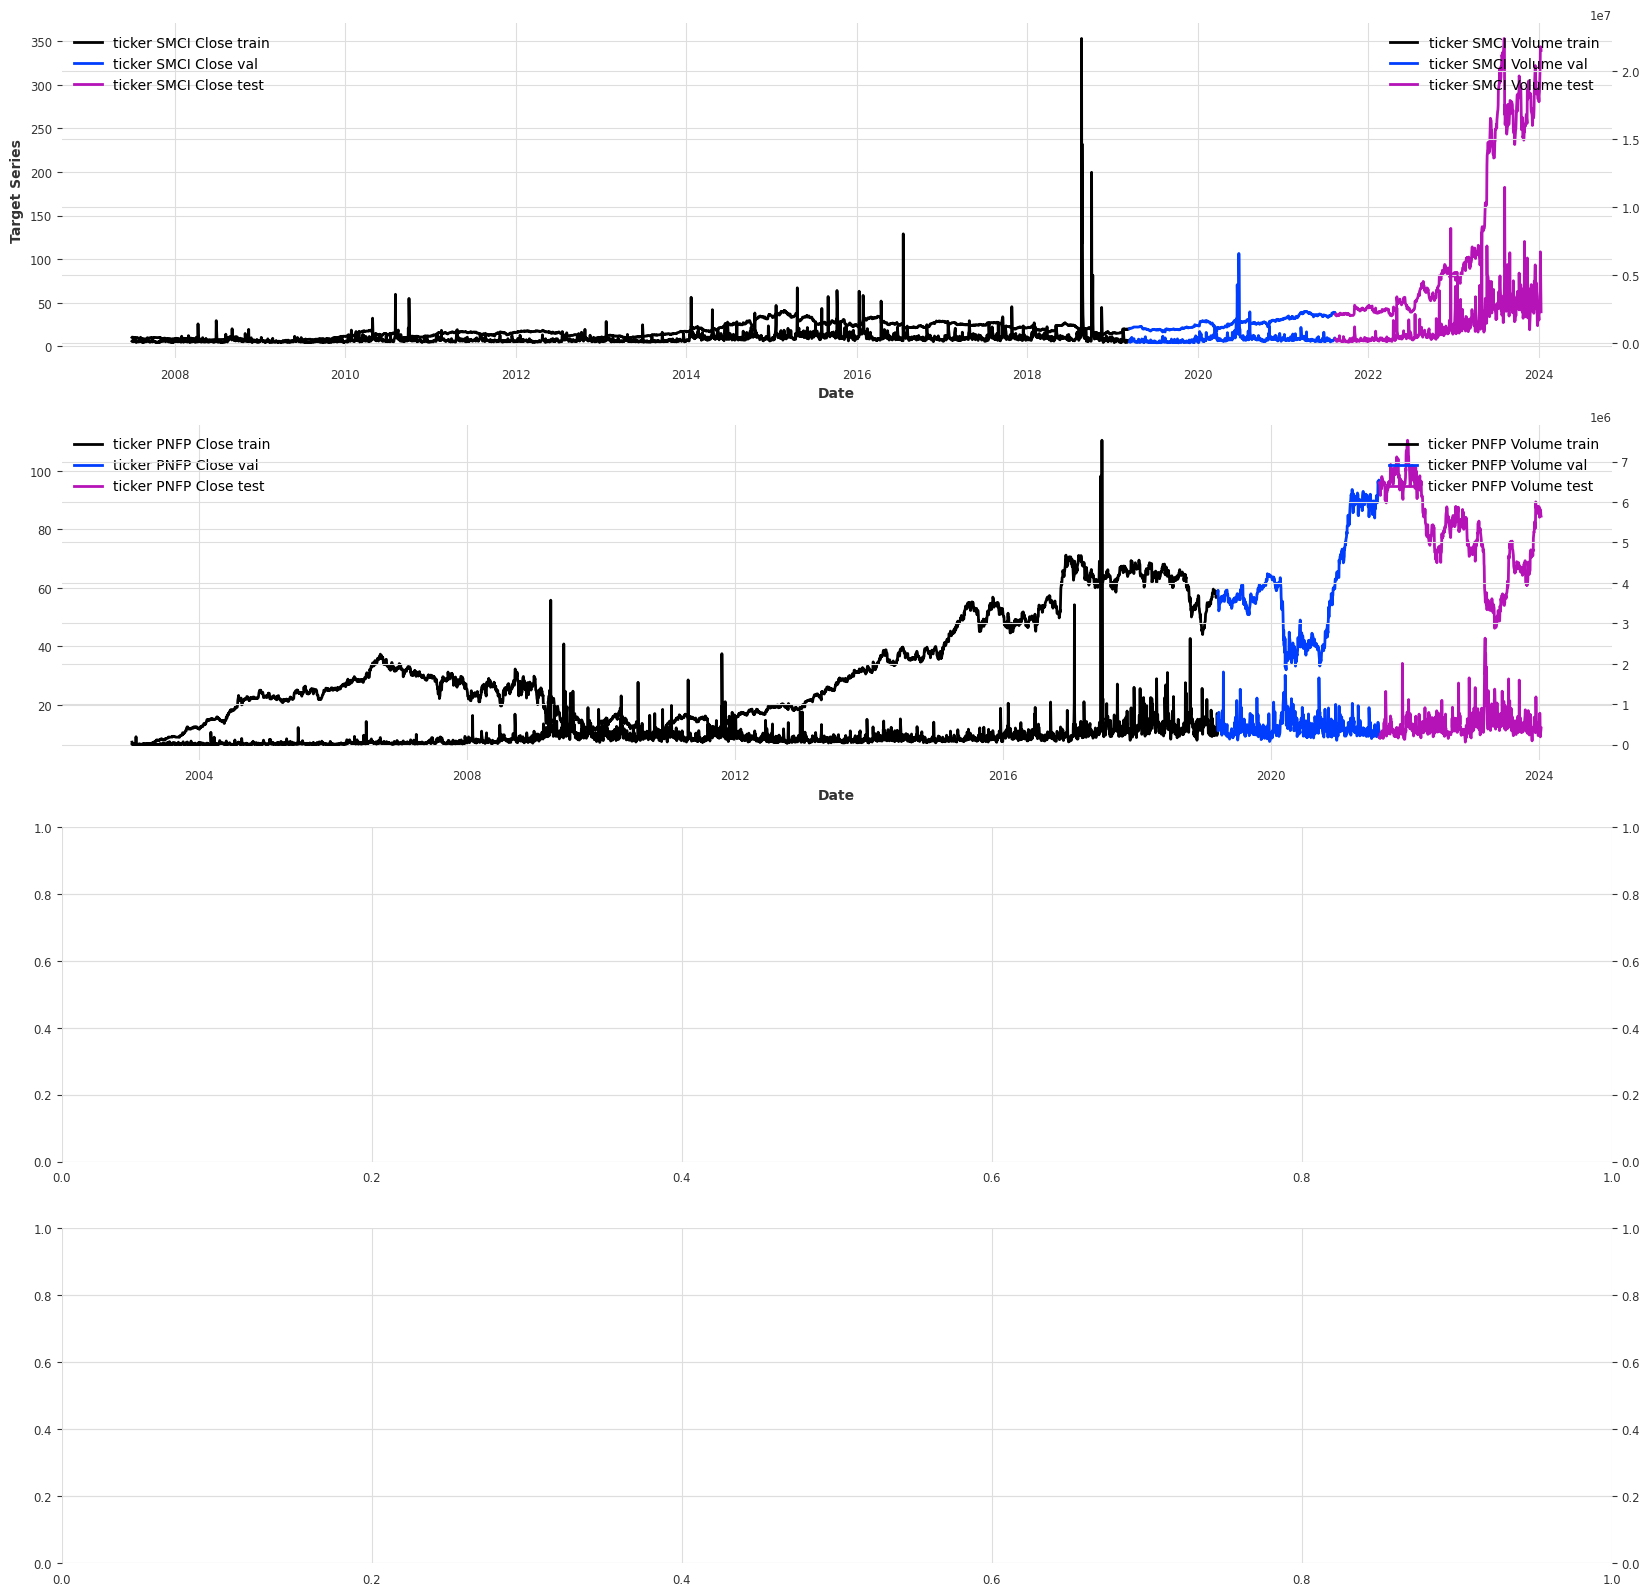

In [161]:
import matplotlib.pyplot as plt

# plot sample of target series
fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 20))
axes2 = {}
for i in range(n_plot_samples):
    axes2[i] = axes[i].twinx()

for i,t in enumerate(target_series.keys()):
    if i > n_plot_samples-1:
        break

    train_series[t]['Close'].plot(label=f'ticker {t} Close train', ax=axes[i])
    train_series[t]['Volume'].plot(label=f'ticker {t} Volume train', ax=axes2[i])

    val_series[t]['Close'].plot(label=f'ticker {t} Close val', ax=axes[i])
    val_series[t]['Volume'].plot(label=f'ticker {t} Volume val', ax=axes2[i])

    test_series[t]['Close'].plot(label=f'ticker {t} Close test', ax=axes[i])
    test_series[t]['Volume'].plot(label=f'ticker {t} Volume test', ax=axes2[i])

axes[0].set_ylabel('Target Series')


Show seasonalities

Text(0, 0.5, 'Seasonality')

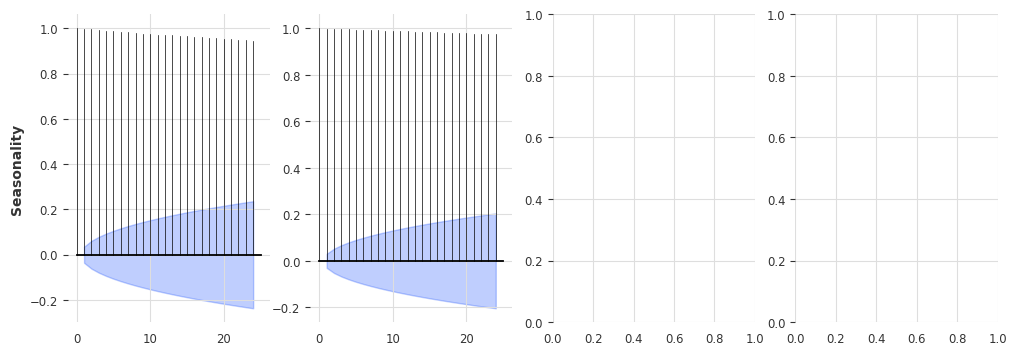

In [162]:
from darts.utils.statistics import plot_acf, check_seasonality

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i >= n_plot_samples:
        break
    plot_acf(train_series[t]['Close'], alpha=0.05, axis=axes[i])

axes[0].set_ylabel('Seasonality')



## Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [163]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
# scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'future': [lambda idx: (idx.year % 4)]},  # signal proximity to US election years, which is known to have significance to market cycles.
    # "transformer": scaler
}



Model hyperparameter selection

In [164]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 2.24e-4,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

In [165]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      add_encoders=None, # encoders,
      hidden_size=512,
      num_encoder_layers=2,
      num_decoder_layers=2,
      decoder_output_dim=32,
      temporal_decoder_hidden=64,
      dropout=0.2,
      use_layer_norm=True,
      use_reversible_instance_norm=True,
      n_epochs=n_epochs,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
      log_tensorboard=True,
      nr_epochs_val_period=2
  )
  


Loading saved model
Error loading saved model: [Errno 2] No such file or directory: 'data/canswim_model.pt'
Creating a new model


In [166]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [167]:
targets_list = [series for ticker, series in sorted(target_series.items())]
target_train_list = [series for ticker, series in sorted(train_series.items())]
print(len(target_train_list))
target_val_list = [series for ticker, series in sorted(val_series.items())]
print(len(target_val_list))
target_test_list = [series for ticker, series in sorted(test_series.items())]
print(len(target_test_list))
past_cov_list = [series for ticker, series in sorted(past_covariates_train.items())]
print(len(past_cov_list))
past_cov_val_list = [series for ticker, series in sorted(past_covariates_val.items())]
print(len(past_cov_val_list))
past_cov_test_list = [series for ticker, series in sorted(past_covariates_test.items())]
print(len(past_cov_test_list))
future_cov_list = [series for ticker, series in sorted(future_covariates.items())]
print(len(future_cov_list))


2
2
2
2
2
2
2


In [168]:
type(target_train_list[0])

darts.timeseries.TimeSeries

In [169]:
print(len(target_train_list[0].time_index))
print(len(past_cov_list[0].time_index))

print(len(target_val_list[0].time_index))
print(len(past_cov_val_list[0].time_index))

print(len(target_test_list[0].time_index))
print(len(past_cov_test_list[0].time_index))

print(len(future_cov_list[0].time_index))


4228
4843
630
630
631
631
5489


In [170]:
target_train_list[0].pd_dataframe()

component,Open,Close,Volume
Date,,,
2002-12-31,6.550000,6.455000,60800.0
2003-01-01,6.505000,6.457500,30600.0
2003-01-02,6.460000,6.460000,400.0
2003-01-03,6.460000,6.450000,22600.0
2003-01-06,6.550000,6.550000,200.0
...,...,...,...
2019-03-08,56.180000,56.970001,325900.0
2019-03-11,57.110001,57.360001,292000.0
2019-03-12,57.470001,57.200001,226700.0


In [171]:
target_train_list[0].start_time(), target_train_list[0].end_time()

(Timestamp('2002-12-31 00:00:00'), Timestamp('2019-03-14 00:00:00'))

In [172]:
past_cov_list[0].pd_dataframe().columns

Index(['High', 'Low', 'Adj Close', 'eps', 'epsEstimated', 'time', 'revenue',
       'revenueEstimated', 'updatedFromDate_day', 'updatedFromDate_month',
       ...
       '^TNX_High', '^TNX_Low', '^TNX_Close', '^TNX_Adj Close', '^IRX_Open',
       '^IRX_High', '^IRX_Low', '^IRX_Close', '^IRX_Adj Close', '^IRX_Volume'],
      dtype='object', name='component', length=136)

In [173]:
past_cov_list[0].pd_dataframe()

component,High,Low,Adj Close,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate_day,updatedFromDate_month,...,^TNX_High,^TNX_Low,^TNX_Close,^TNX_Adj Close,^IRX_Open,^IRX_High,^IRX_Low,^IRX_Close,^IRX_Adj Close,^IRX_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-22,4.750000,4.750000,4.258024,-1.0,0.04,1.0,-1.0,2.891937e+06,-1.0,-1.0,...,5.783,5.762,5.762,5.762,6.090,6.090,6.080,6.080,6.080,0.0
2000-08-23,4.812500,4.750000,4.314051,-1.0,0.04,1.0,-1.0,2.891937e+06,-1.0,-1.0,...,5.746,5.721,5.725,5.725,6.080,6.090,6.080,6.090,6.090,0.0
2000-08-24,4.812500,4.750000,4.258024,-1.0,0.04,1.0,-1.0,2.891937e+06,-1.0,-1.0,...,5.729,5.683,5.716,5.716,6.090,6.110,6.090,6.090,6.090,0.0
2000-08-25,4.812500,4.750000,4.286037,-1.0,0.04,1.0,-1.0,2.891937e+06,-1.0,-1.0,...,5.737,5.700,5.721,5.721,6.110,6.110,6.100,6.110,6.110,0.0
2000-08-28,4.781250,4.750000,4.258024,-1.0,0.04,1.0,-1.0,2.891937e+06,-1.0,-1.0,...,5.783,5.708,5.766,5.766,6.110,6.140,6.110,6.130,6.130,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-08,57.509998,56.060001,53.927082,-1.0,1.21,1.0,-1.0,2.325435e+08,-1.0,-1.0,...,2.652,2.607,2.625,2.625,2.395,2.395,2.390,2.393,2.393,0.0
2019-03-11,57.730000,56.810001,54.296261,-1.0,1.21,1.0,-1.0,2.325435e+08,-1.0,-1.0,...,2.652,2.632,2.643,2.643,2.393,2.393,2.380,2.380,2.380,0.0
2019-03-12,57.779999,56.919998,54.144810,-1.0,1.21,1.0,-1.0,2.325435e+08,-1.0,-1.0,...,2.656,2.600,2.605,2.605,2.395,2.395,2.393,2.395,2.395,0.0


In [174]:
past_cov_list[0].start_time(), past_cov_list[0].end_time()

(Timestamp('2000-08-22 00:00:00'), Timestamp('2019-03-14 00:00:00'))

In [175]:
target_val_list[0].start_time(), target_val_list[0].end_time()

(Timestamp('2019-03-15 00:00:00'), Timestamp('2021-08-12 00:00:00'))

In [176]:
past_cov_val_list[0].start_time(), past_cov_val_list[0].end_time()

(Timestamp('2019-03-15 00:00:00'), Timestamp('2021-08-12 00:00:00'))

In [177]:
target_test_list[0].start_time(), target_test_list[0].end_time()

(Timestamp('2021-08-13 00:00:00'), Timestamp('2024-01-12 00:00:00'))

In [178]:
past_cov_test_list[0].start_time(), past_cov_test_list[0].end_time()

(Timestamp('2021-08-13 00:00:00'), Timestamp('2024-01-12 00:00:00'))

In [179]:
n_holidays = future_cov_list[0].pd_dataframe().sum()
n_holidays

component
holidays                               2.140000e+02
estimatedRevenueLow_p_1                2.467768e+12
estimatedRevenueHigh_p_1               2.634030e+12
estimatedRevenueAvg_p_1                2.563679e+12
estimatedEbitdaLow_p_1                 3.067918e+11
                                           ...     
numberAnalystEstimatedRevenue_p_2_1    1.383860e+05
numberAnalystsEstimatedEps_p_2_1       1.425680e+05
fiscalDateEnding_day_p_2_1             1.701590e+05
fiscalDateEnding_month_p_2_1           6.586800e+04
fiscalDateEnding_year_p_2_1            1.105495e+07
Length: 139, dtype: float64

In [180]:
future_cov_list[0].columns

Index(['holidays', 'estimatedRevenueLow_p_1', 'estimatedRevenueHigh_p_1',
       'estimatedRevenueAvg_p_1', 'estimatedEbitdaLow_p_1',
       'estimatedEbitdaHigh_p_1', 'estimatedEbitdaAvg_p_1',
       'estimatedEbitLow_p_1', 'estimatedEbitHigh_p_1', 'estimatedEbitAvg_p_1',
       ...
       'estimatedSgaExpenseHigh_p_2_1', 'estimatedSgaExpenseAvg_p_2_1',
       'estimatedEpsAvg_p_2_1', 'estimatedEpsHigh_p_2_1',
       'estimatedEpsLow_p_2_1', 'numberAnalystEstimatedRevenue_p_2_1',
       'numberAnalystsEstimatedEps_p_2_1', 'fiscalDateEnding_day_p_2_1',
       'fiscalDateEnding_month_p_2_1', 'fiscalDateEnding_year_p_2_1'],
      dtype='object', name='component', length=139)

In [181]:
future_cov_list[0].start_time(), future_cov_list[0].end_time()

(Timestamp('2002-12-31 00:00:00'), Timestamp('2024-01-12 00:00:00'))

### Run model training loop

In [182]:
# train model
# for i in range(100):
model.fit(target_train_list, epochs=n_epochs, past_covariates=past_cov_list, future_covariates=future_cov_list, 
          val_series=target_val_list, val_past_covariates=past_cov_val_list, val_future_covariates=future_cov_list,
          verbose=True, num_loader_workers=10, )
          # val_series=target_val_list[0]) # , val_future_covariates=future_cov_list[0]) 



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 6     
4 | past_cov_projection   | _ResidualBlock   | 72.8 K
5 | future_cov_projection | _ResidualBlock   | 74.3 K
6 | encoders              | Sequential       | 6.9 M 
7 | decoders              | Sequential       | 10.7 M
8 | temporal_decoder      | _ResidualBlock   | 20.9 K
9 | lookback_skip         | Linear           | 148 K 
-----------------------------------------------------------
17.9 M    Trainable params
0         Non-trainable params
17.9 M    Total params
71.769    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

### Save model checkpoint

In [ ]:
# save model checkpoint
model.save(saved_model_name)


In [ ]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
# pred = model.predict(pred_horizon, series=target_train_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)

## Test Model Forecasting

In [ ]:
# pred[0]

In [ ]:
# pred[0].gaps()

In [ ]:
#pred2_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=60))
#pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred2

### Plot several forecasts at various future starting points

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

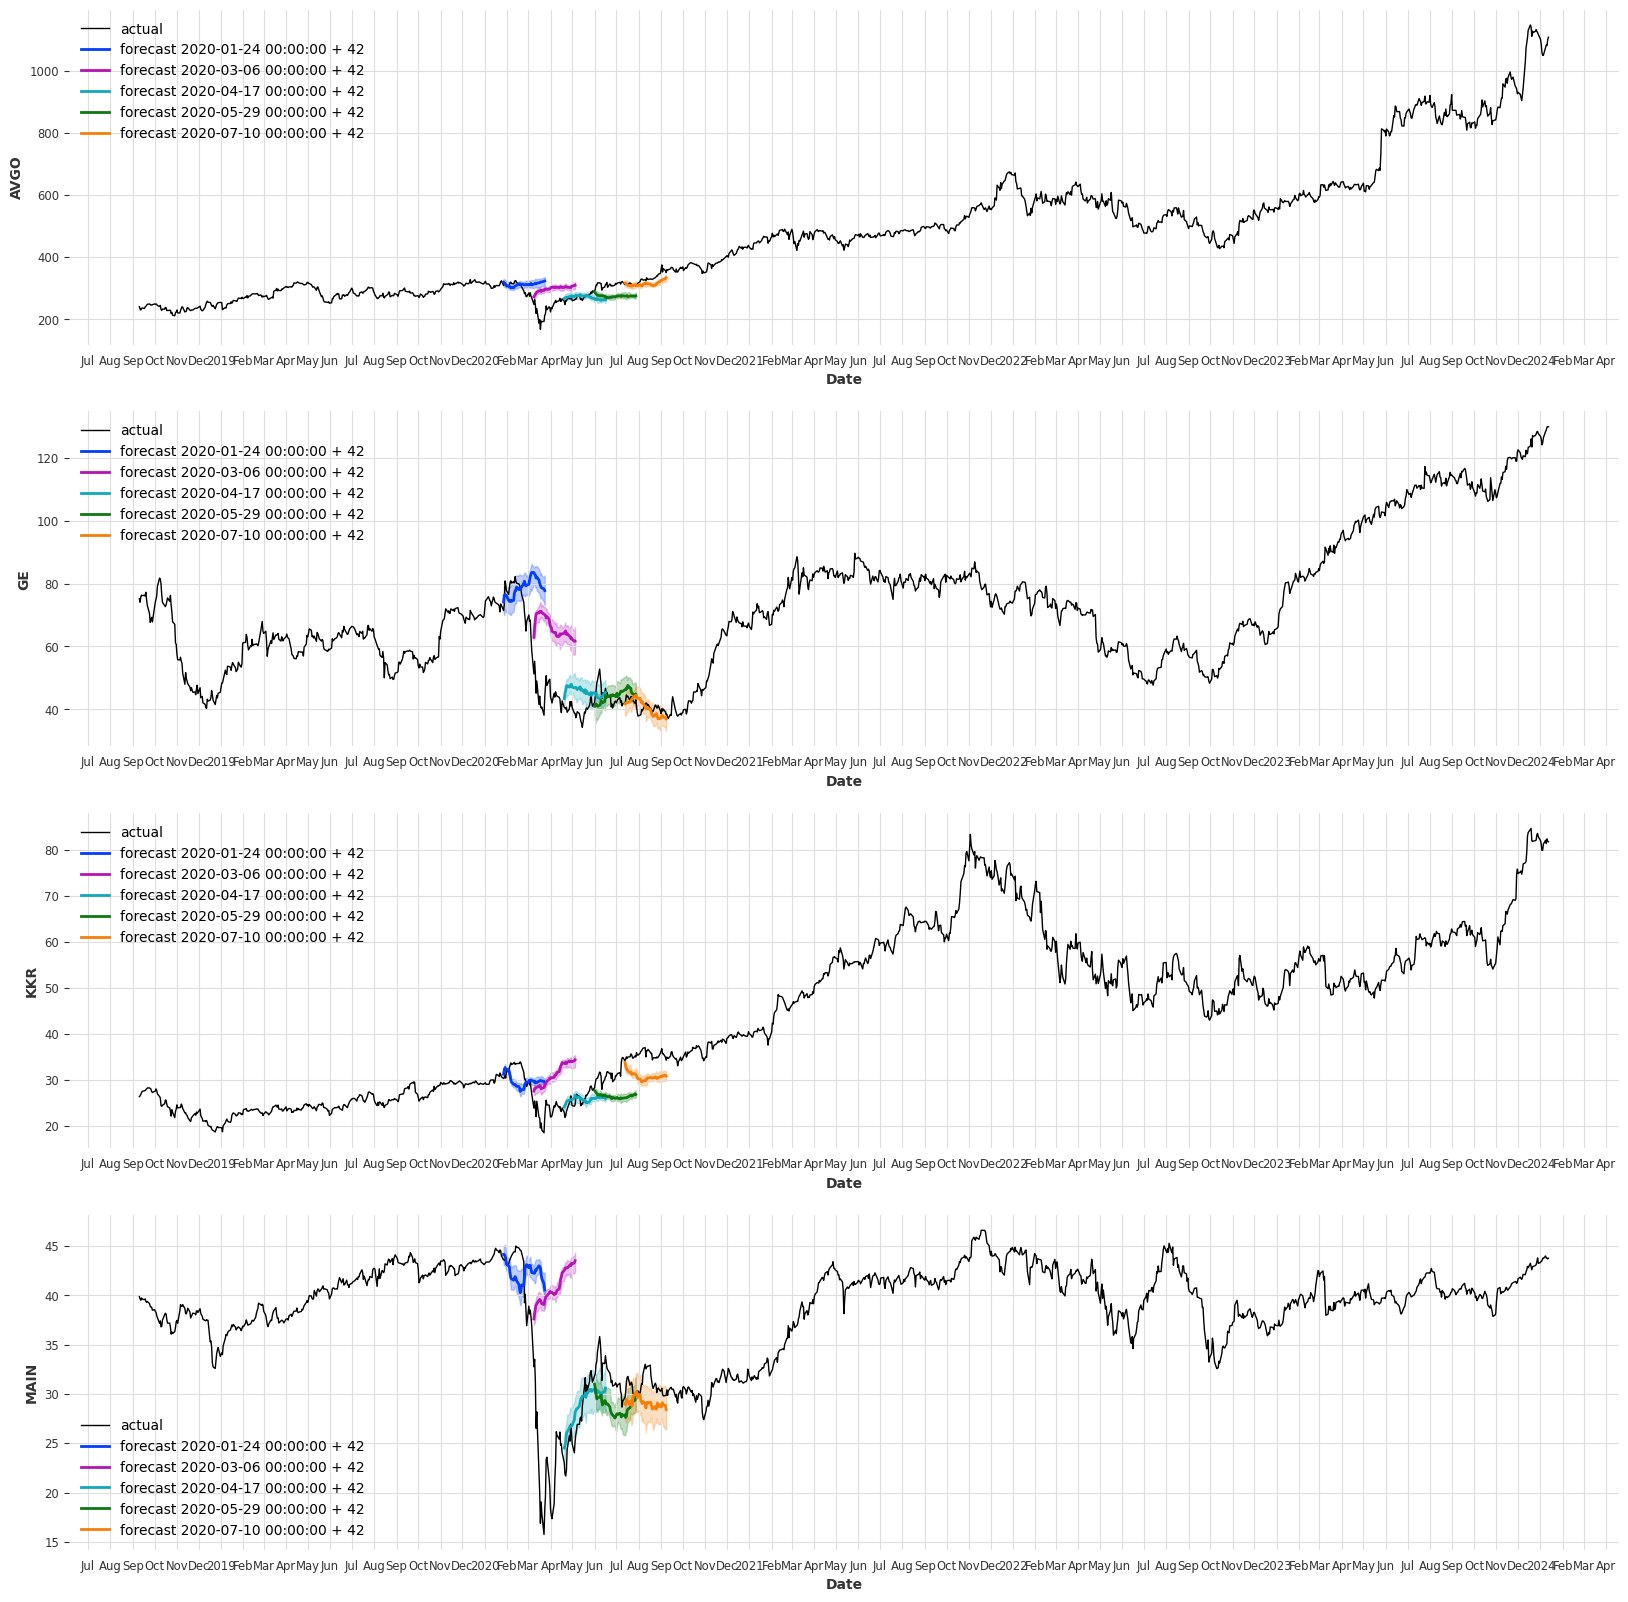

In [ ]:
import matplotlib.dates as mdates

# select a reasonable range of train and val data points for convenient visualization of results
actual = {}

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 20))


def get_pred_list(pred_start=None):
    pred_list = []
    for t, target in sorted(target_series.items()):
        pred_series = target.slice(target.start_time(), pred_start-pd.Timedelta(days=1))
        pred_list.append(pred_series)
    return pred_list


def get_past_covs(start=None):
    past_cov_list = []
    for t, past_cov in sorted(past_covariates.items()):
        past_covs_sliced = past_cov.slice(past_cov.start_time(), pred_start-pd.Timedelta(days=1))
        past_cov_list.append(past_covs_sliced)
    return past_cov_list


def plot_pred(pred_list=None, past_cov_list=None):
    #pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
    pred = model.predict(pred_horizon, series=pred_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            # tsliced = target_series[t]
            # actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
            # ax = actual[t].plot(label='actual', ax=axes[i])
            ax = pred[i].plot(label=f'forecast {pred_list[0].end_time()} + {pred_horizon}', linewidth=2, ax=axes[i])
            #pred2.plot(label=f'forecast {pred2_series.end_time()} + {pred_horizon}')
            plt.legend()
            # Major ticks every half year, minor ticks every month,
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
            ax.grid(True)
            ax.set_ylabel(f'{t}')


def plot_actual():
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            tsliced = target_series[t]
            actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
            ax = actual[t].plot(label='actual', linewidth=1, ax=axes[i])

plot_actual()

# show predictions at several points in time over the validation set
for w in range(5):
    pred_start = val_start + pd.Timedelta(days=w*pred_horizon)
    pred_list = get_pred_list(pred_start)
    past_cov_list = get_past_covs(pred_start)
    # print(f'pred_list: \n{pred_list}')
    plot_pred(pred_list=pred_list, past_cov_list=past_cov_list)



### Backtest Model


In [ ]:
# Backtest model on the full range of test data
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the val portion of the flow series, with a forecast_horizon:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          overlap_end=True,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 10, 'n_jobs': -1}
                                          )
    
    return backtest


In [ ]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
forecast_start = val_start-pd.Timedelta(days=120)
forecast_horizon = pred_horizon # pred_horizon

backtest = eval_model(model=model, series=targets_list[:n_plot_samples], start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_cov_list[:n_plot_samples], future_covariates=future_cov_list[:n_plot_samples])


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


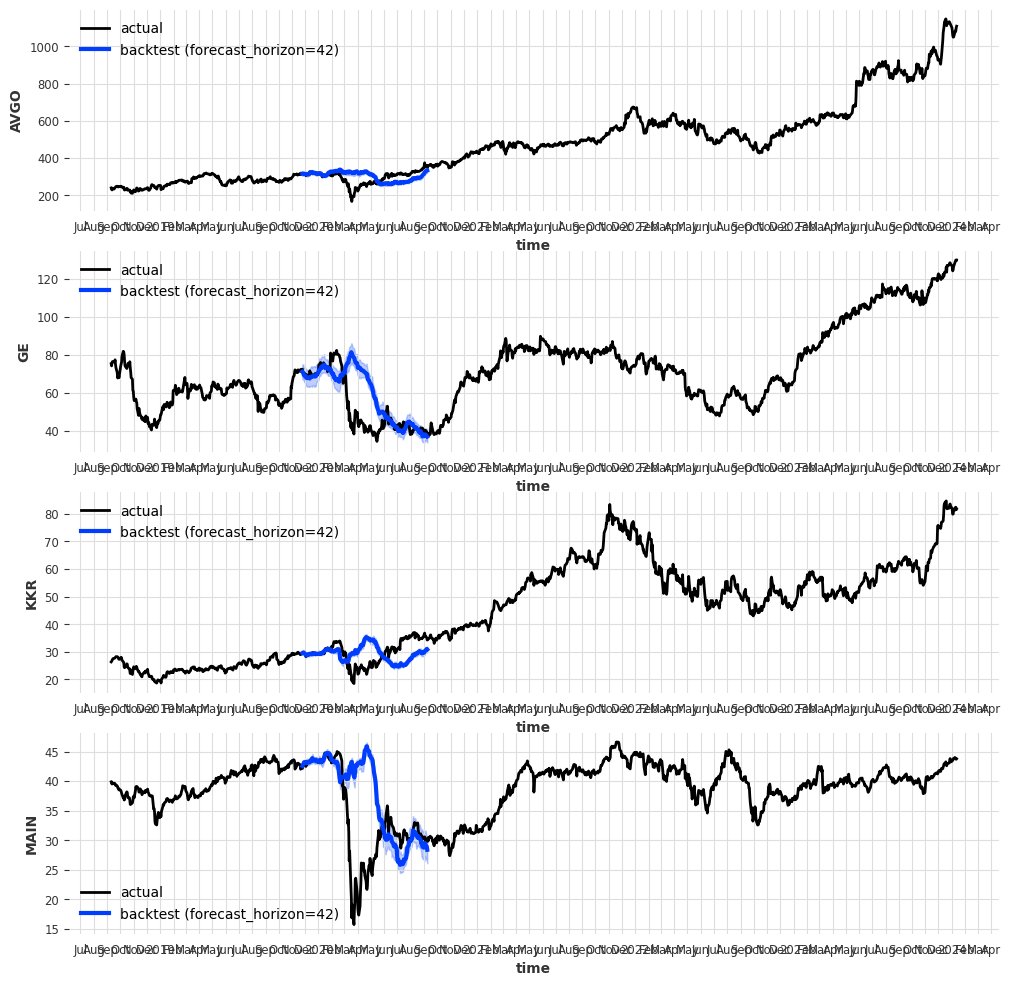

In [ ]:

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))

for i,t in enumerate(sorted(train_series.keys())):
    if i < n_plot_samples:
        tsliced = target_series[t]
        actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
        ax = actual[t].plot(label='actual', ax=axes[i])
        backtest[i].plot(label=f'backtest (forecast_horizon={forecast_horizon})', linewidth=3, ax=axes[i])
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')



In [ ]:
print('Backtest RMSE = {}'.format(rmse(target_train_list[:n_plot_samples], backtest)))


Backtest RMSE = [3.5314028814566556, 1.4569965454606815, 0.31513362658335625, 0.2760927391847857]
